In [23]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [24]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full_corrected.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full_corrected.csv
Name of the anagraphic dataset: labels.csv


In [25]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    return data, labels

In [26]:
def print_feats(feats):
    cur, idx = [], 0
    for feat in feats:
        cur.append(str(feat))
        idx += 1
        if (idx % 5) == 0:
            print(', '.join(cur) + ',')
            cur = []
    if len(cur) > 0:
        print(', '.join(cur))

In [27]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]

In [28]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]


# ML Approach

In [29]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(1000):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    return plot_compounded(results, feat_to_predict)


### Full Data

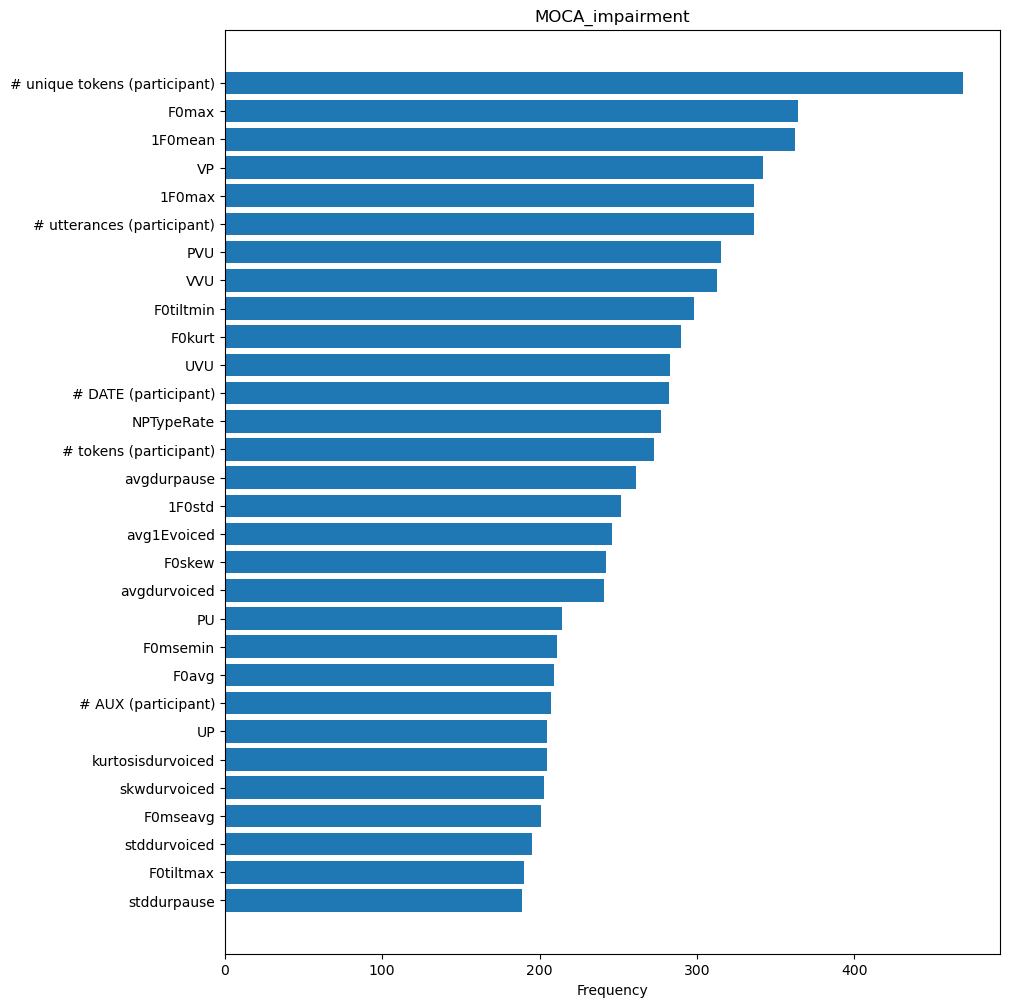

# unique tokens (participant), F0max, 1F0mean, VP, 1F0max,
# utterances (participant), PVU, VVU, F0tiltmin, F0kurt,
UVU, # DATE (participant), NPTypeRate, # tokens (participant), avgdurpause,
1F0std, avg1Evoiced, F0skew, avgdurvoiced, PU,
F0msemin, F0avg, # AUX (participant), UP, kurtosisdurvoiced,
skwdurvoiced, F0mseavg, stddurvoiced, F0tiltmax, stddurpause,


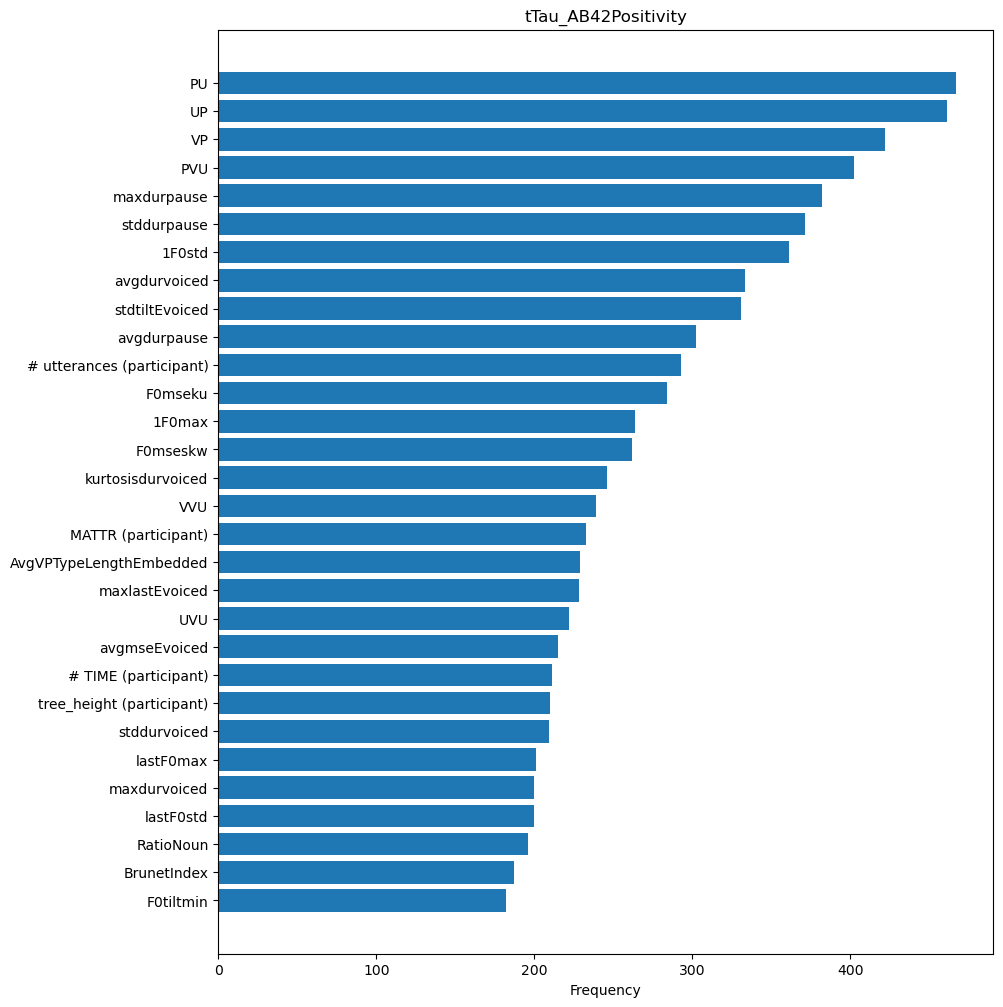

PU, UP, VP, PVU, maxdurpause,
stddurpause, 1F0std, avgdurvoiced, stdtiltEvoiced, avgdurpause,
# utterances (participant), F0mseku, 1F0max, F0mseskw, kurtosisdurvoiced,
VVU, MATTR (participant), AvgVPTypeLengthEmbedded, maxlastEvoiced, UVU,
avgmseEvoiced, # TIME (participant), tree_height (participant), stddurvoiced, lastF0max,
maxdurvoiced, lastF0std, RatioNoun, BrunetIndex, F0tiltmin,


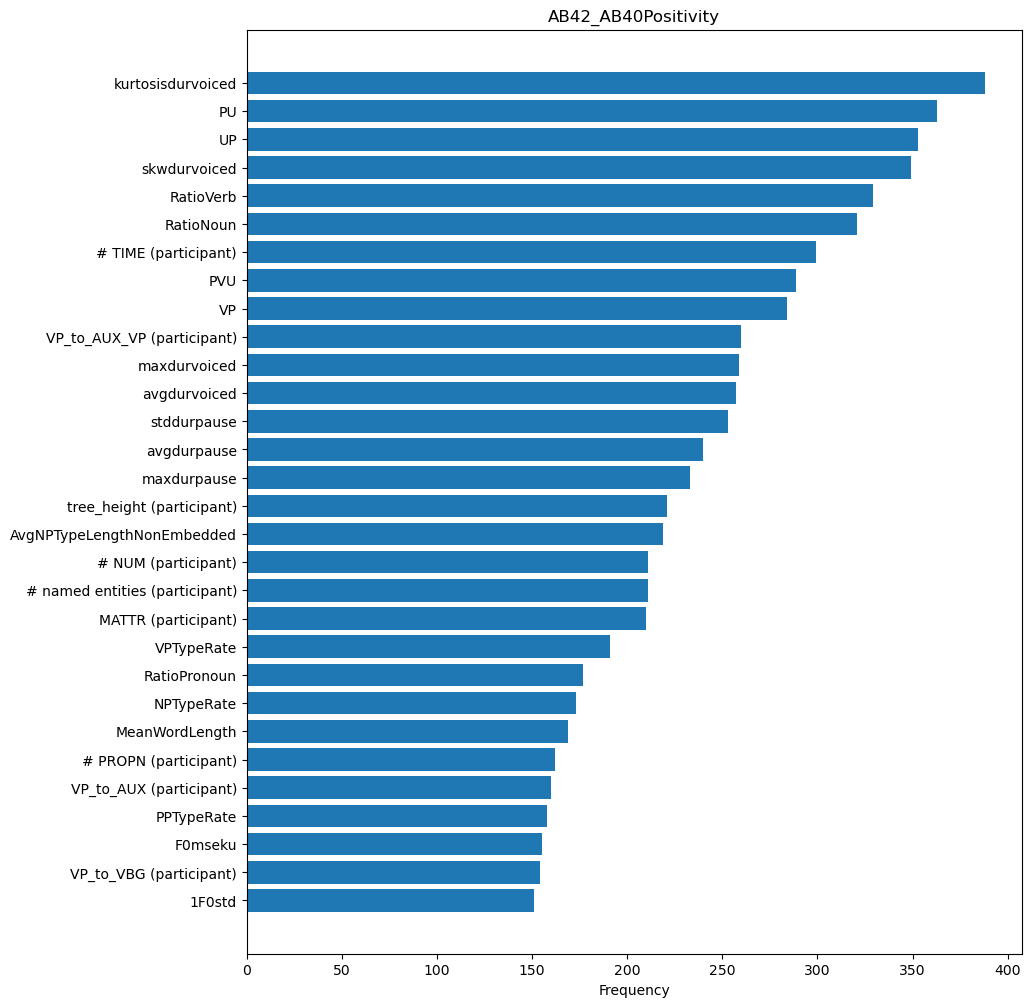

kurtosisdurvoiced, PU, UP, skwdurvoiced, RatioVerb,
RatioNoun, # TIME (participant), PVU, VP, VP_to_AUX_VP (participant),
maxdurvoiced, avgdurvoiced, stddurpause, avgdurpause, maxdurpause,
tree_height (participant), AvgNPTypeLengthNonEmbedded, # NUM (participant), # named entities (participant), MATTR (participant),
VPTypeRate, RatioPronoun, NPTypeRate, MeanWordLength, # PROPN (participant),
VP_to_AUX (participant), PPTypeRate, F0mseku, VP_to_VBG (participant), 1F0std,


In [31]:
MOCA_ML_FULL_COMPUTED_FEATURES = ml_analysis('MOCA_impairment')
TTAU_ML_FULL_COMPUTED_FEATURES = ml_analysis('tTau_AB42Positivity')
AB42_ML_FULL_COMPUTED_FEATURES = ml_analysis('AB42_AB40Positivity')

### No Audio

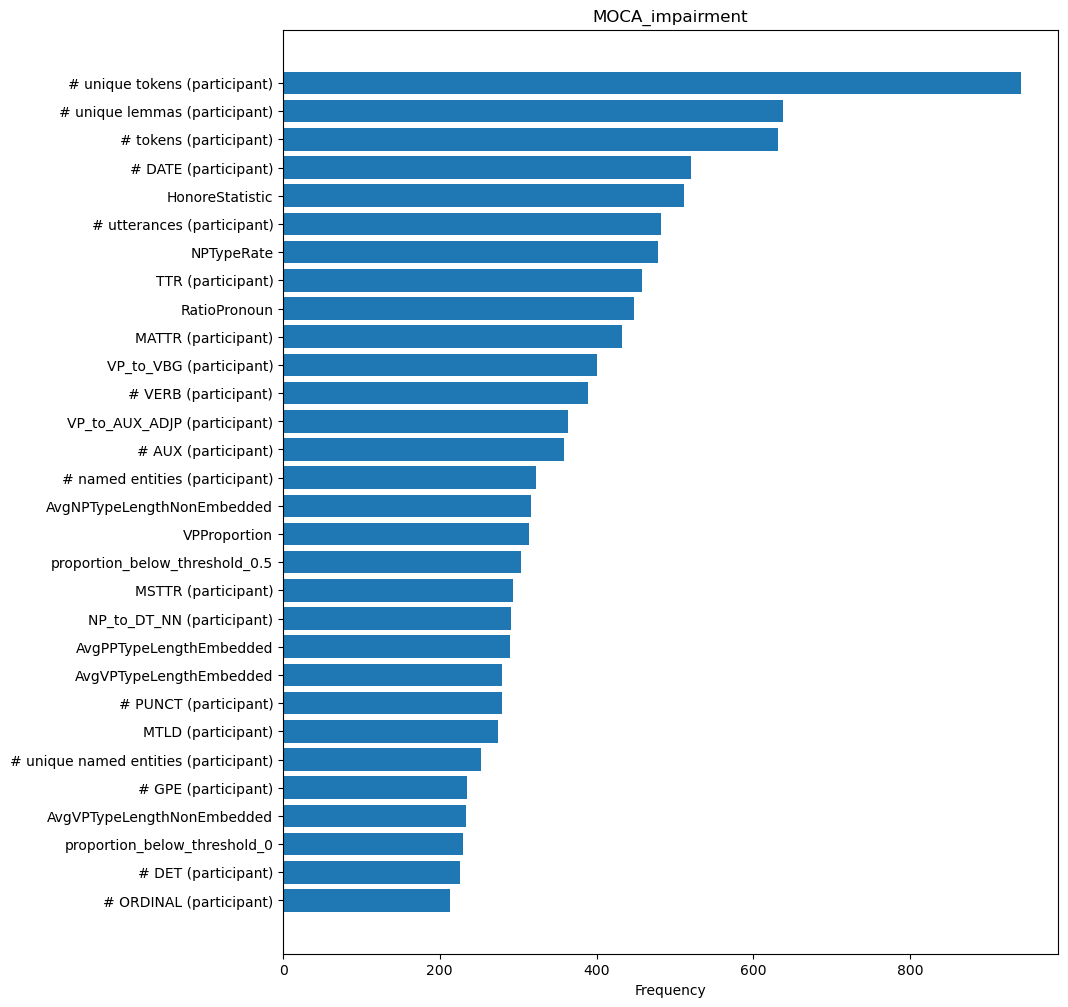

# unique tokens (participant), # unique lemmas (participant), # tokens (participant), # DATE (participant), HonoreStatistic,
# utterances (participant), NPTypeRate, TTR (participant), RatioPronoun, MATTR (participant),
VP_to_VBG (participant), # VERB (participant), VP_to_AUX_ADJP (participant), # AUX (participant), # named entities (participant),
AvgNPTypeLengthNonEmbedded, VPProportion, proportion_below_threshold_0.5, MSTTR (participant), NP_to_DT_NN (participant),
AvgPPTypeLengthEmbedded, AvgVPTypeLengthEmbedded, # PUNCT (participant), MTLD (participant), # unique named entities (participant),
# GPE (participant), AvgVPTypeLengthNonEmbedded, proportion_below_threshold_0, # DET (participant), # ORDINAL (participant),


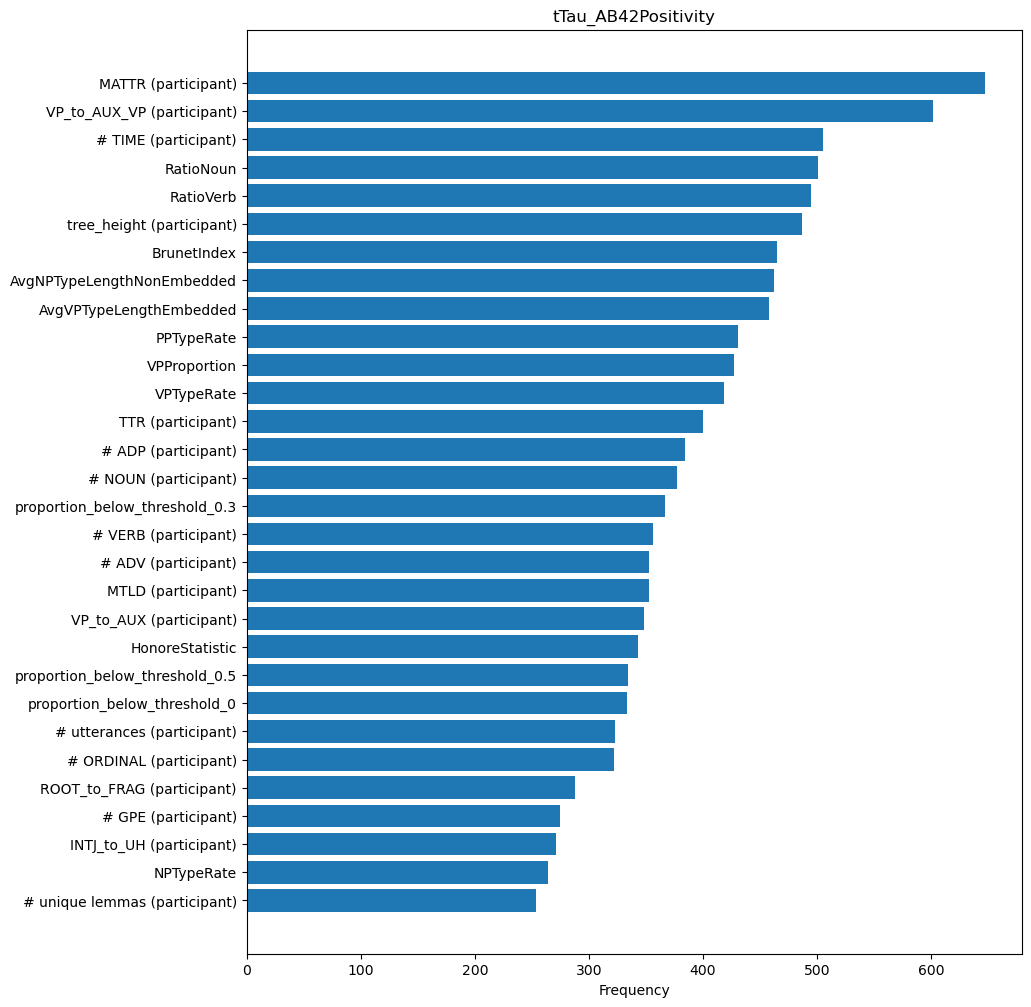

MATTR (participant), VP_to_AUX_VP (participant), # TIME (participant), RatioNoun, RatioVerb,
tree_height (participant), BrunetIndex, AvgNPTypeLengthNonEmbedded, AvgVPTypeLengthEmbedded, PPTypeRate,
VPProportion, VPTypeRate, TTR (participant), # ADP (participant), # NOUN (participant),
proportion_below_threshold_0.3, # VERB (participant), # ADV (participant), MTLD (participant), VP_to_AUX (participant),
HonoreStatistic, proportion_below_threshold_0.5, proportion_below_threshold_0, # utterances (participant), # ORDINAL (participant),
ROOT_to_FRAG (participant), # GPE (participant), INTJ_to_UH (participant), NPTypeRate, # unique lemmas (participant),


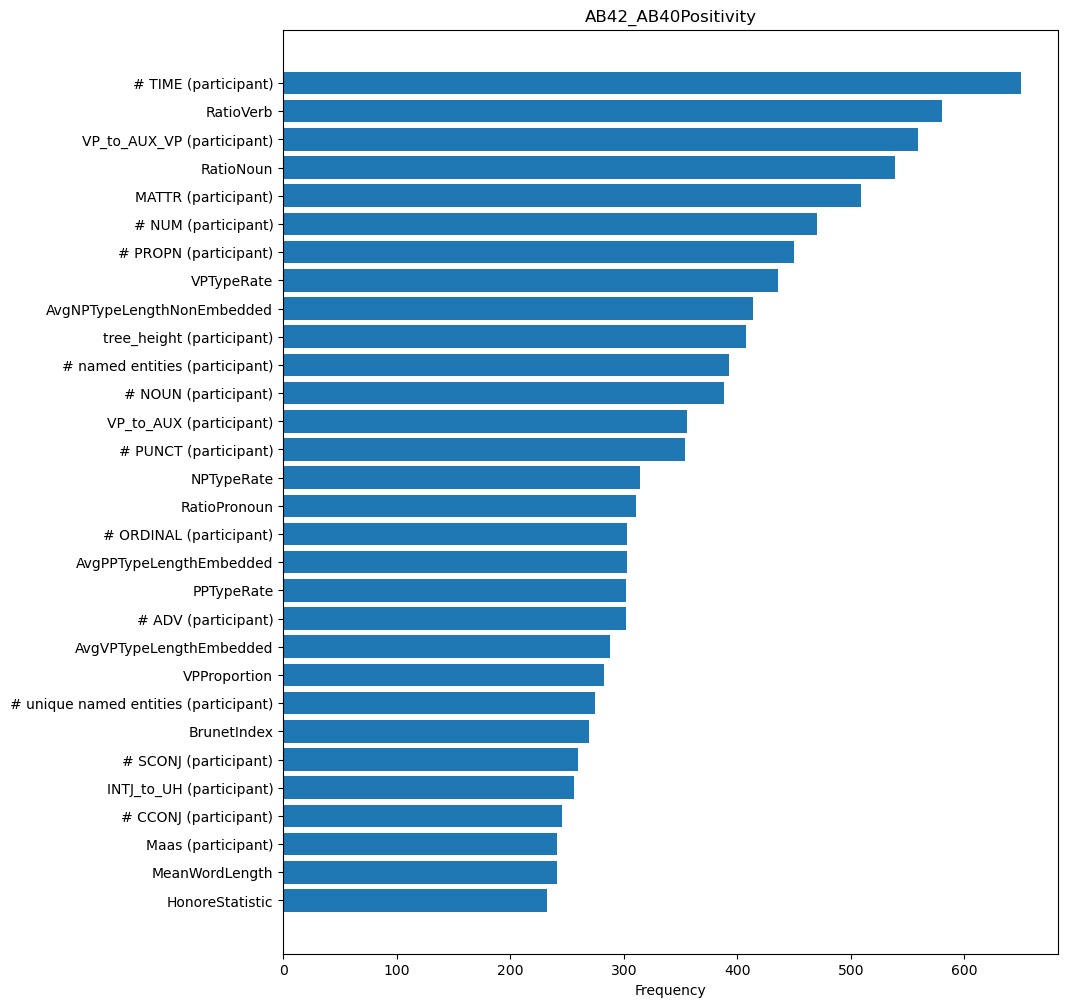

# TIME (participant), RatioVerb, VP_to_AUX_VP (participant), RatioNoun, MATTR (participant),
# NUM (participant), # PROPN (participant), VPTypeRate, AvgNPTypeLengthNonEmbedded, tree_height (participant),
# named entities (participant), # NOUN (participant), VP_to_AUX (participant), # PUNCT (participant), NPTypeRate,
RatioPronoun, # ORDINAL (participant), AvgPPTypeLengthEmbedded, PPTypeRate, # ADV (participant),
AvgVPTypeLengthEmbedded, VPProportion, # unique named entities (participant), BrunetIndex, # SCONJ (participant),
INTJ_to_UH (participant), # CCONJ (participant), Maas (participant), MeanWordLength, HonoreStatistic,


In [10]:
MOCA_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('MOCA_impairment', audio=False)
TTAU_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('tTau_AB42Positivity', audio=False)
AB42_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('AB42_AB40Positivity', audio=False)

# Statistical Approach

In [32]:
def get_topK(X, y, cols, score_func, k=32):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    # Obtain the scores for all the features
    scores = list(select.fit(X, y).scores_)
    # Associate each score to the feature that is related to
    n_scores = list(zip(scores, [i for i in range(len(scores))]))
    # Sort the scores from highest to lowest
    n_scores.sort(key=lambda x: x[0], reverse=True)
    # Retrieve scores and features indexes
    scores, pos = zip(*n_scores)
    # Save top-k scores and their feature names
    top_scores.append(list(scores[:k]))
    top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [33]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    return plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Full Data

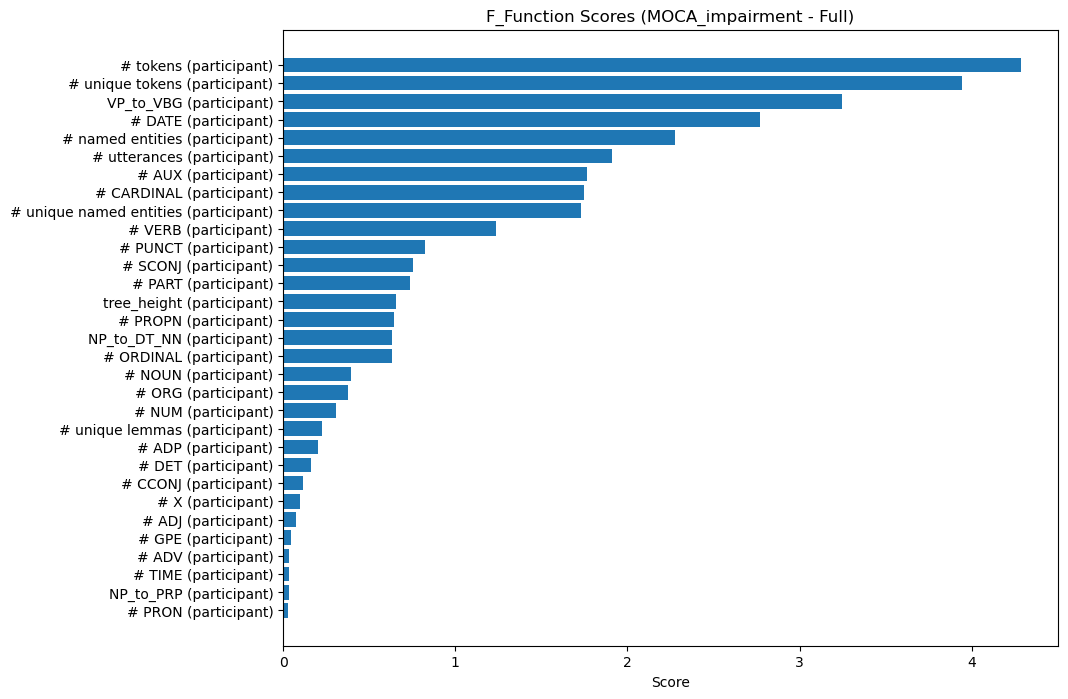

# tokens (participant), # unique tokens (participant), VP_to_VBG (participant), # DATE (participant), # named entities (participant),
# utterances (participant), # AUX (participant), # CARDINAL (participant), # unique named entities (participant), # VERB (participant),
# PUNCT (participant), # SCONJ (participant), # PART (participant), tree_height (participant), # PROPN (participant),
NP_to_DT_NN (participant), # ORDINAL (participant), # NOUN (participant), # ORG (participant), # NUM (participant),
# unique lemmas (participant), # ADP (participant), # DET (participant), # CCONJ (participant), # X (participant),
# ADJ (participant), # GPE (participant), # ADV (participant), # TIME (participant), NP_to_PRP (participant),
# PRON (participant)


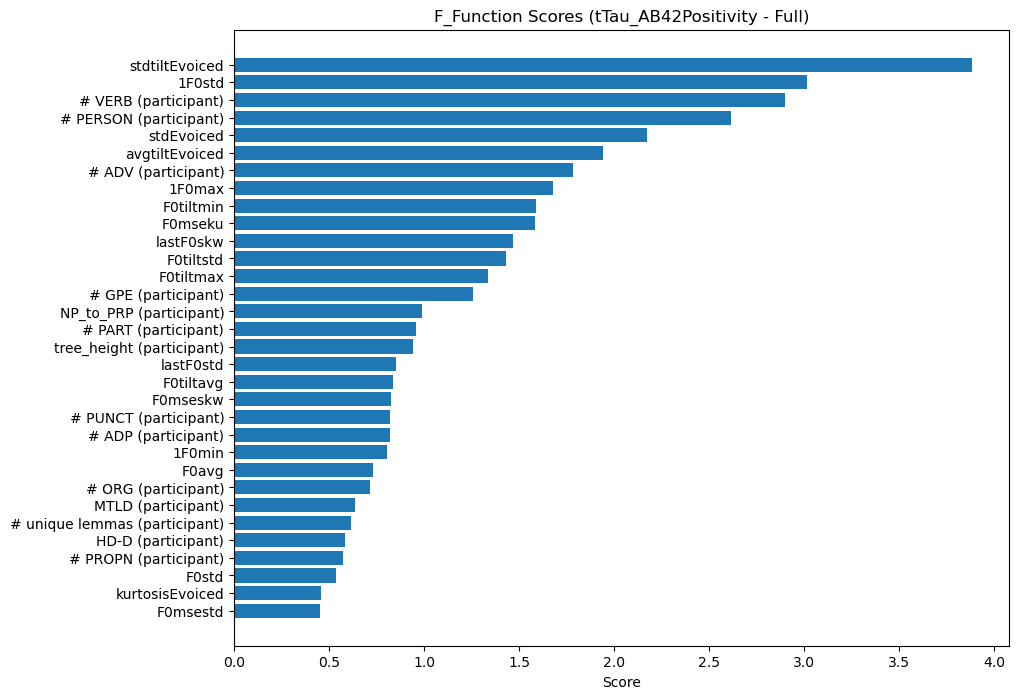

stdtiltEvoiced, 1F0std, # VERB (participant), # PERSON (participant), stdEvoiced,
avgtiltEvoiced, # ADV (participant), 1F0max, F0tiltmin, F0mseku,
lastF0skw, F0tiltstd, F0tiltmax, # GPE (participant), NP_to_PRP (participant),
# PART (participant), tree_height (participant), lastF0std, F0tiltavg, F0mseskw,
# PUNCT (participant), # ADP (participant), 1F0min, F0avg, # ORG (participant),
MTLD (participant), # unique lemmas (participant), HD-D (participant), # PROPN (participant), F0std,
kurtosisEvoiced, F0msestd


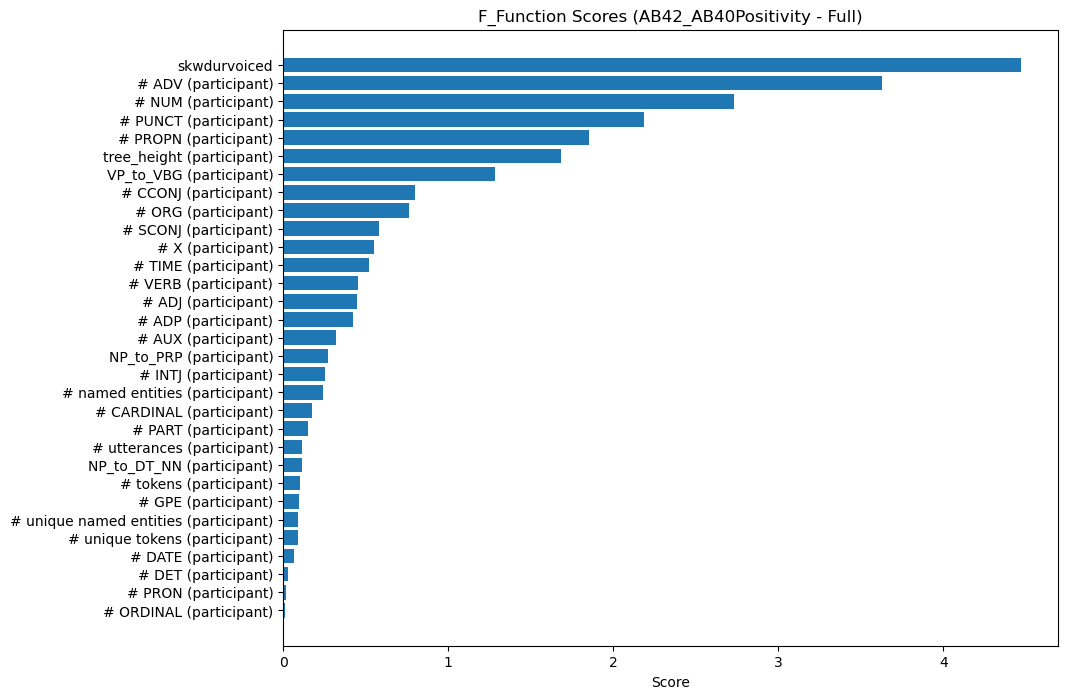

skwdurvoiced, # ADV (participant), # NUM (participant), # PUNCT (participant), # PROPN (participant),
tree_height (participant), VP_to_VBG (participant), # CCONJ (participant), # ORG (participant), # SCONJ (participant),
# X (participant), # TIME (participant), # VERB (participant), # ADJ (participant), # ADP (participant),
# AUX (participant), NP_to_PRP (participant), # INTJ (participant), # named entities (participant), # CARDINAL (participant),
# PART (participant), # utterances (participant), NP_to_DT_NN (participant), # tokens (participant), # GPE (participant),
# unique named entities (participant), # unique tokens (participant), # DATE (participant), # DET (participant), # PRON (participant),
# ORDINAL (participant)


In [34]:
MOCA_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('MOCA_impairment')
TTAU_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('tTau_AB42Positivity')
AB42_F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('AB42_AB40Positivity')

### No Audio

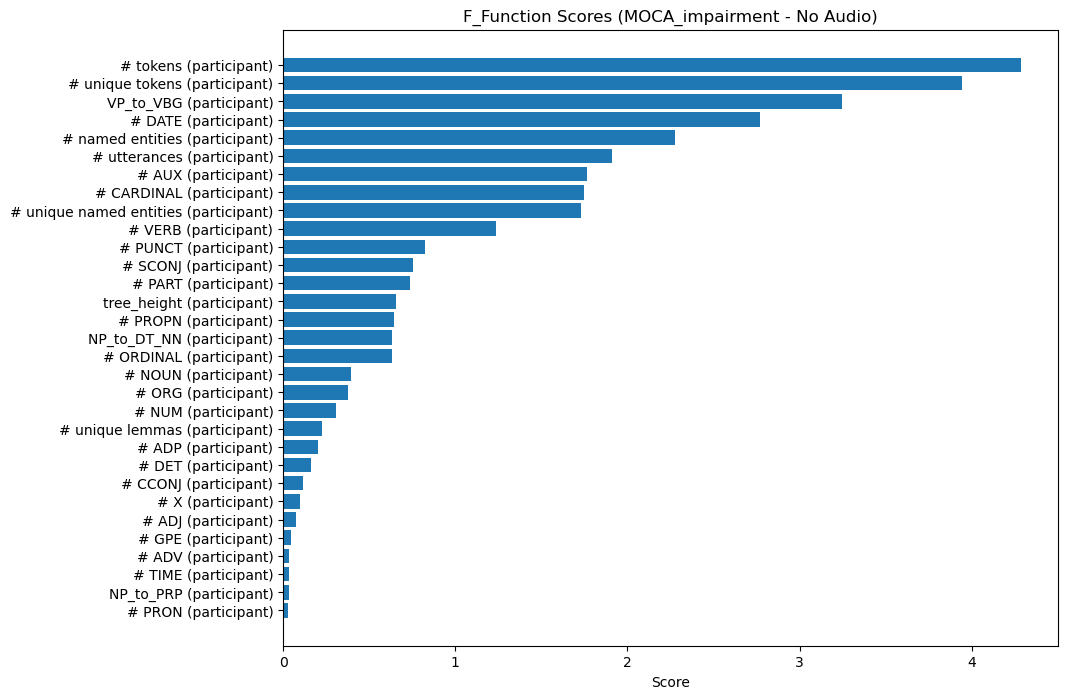

# tokens (participant), # unique tokens (participant), VP_to_VBG (participant), # DATE (participant), # named entities (participant),
# utterances (participant), # AUX (participant), # CARDINAL (participant), # unique named entities (participant), # VERB (participant),
# PUNCT (participant), # SCONJ (participant), # PART (participant), tree_height (participant), # PROPN (participant),
NP_to_DT_NN (participant), # ORDINAL (participant), # NOUN (participant), # ORG (participant), # NUM (participant),
# unique lemmas (participant), # ADP (participant), # DET (participant), # CCONJ (participant), # X (participant),
# ADJ (participant), # GPE (participant), # ADV (participant), # TIME (participant), NP_to_PRP (participant),
# PRON (participant)


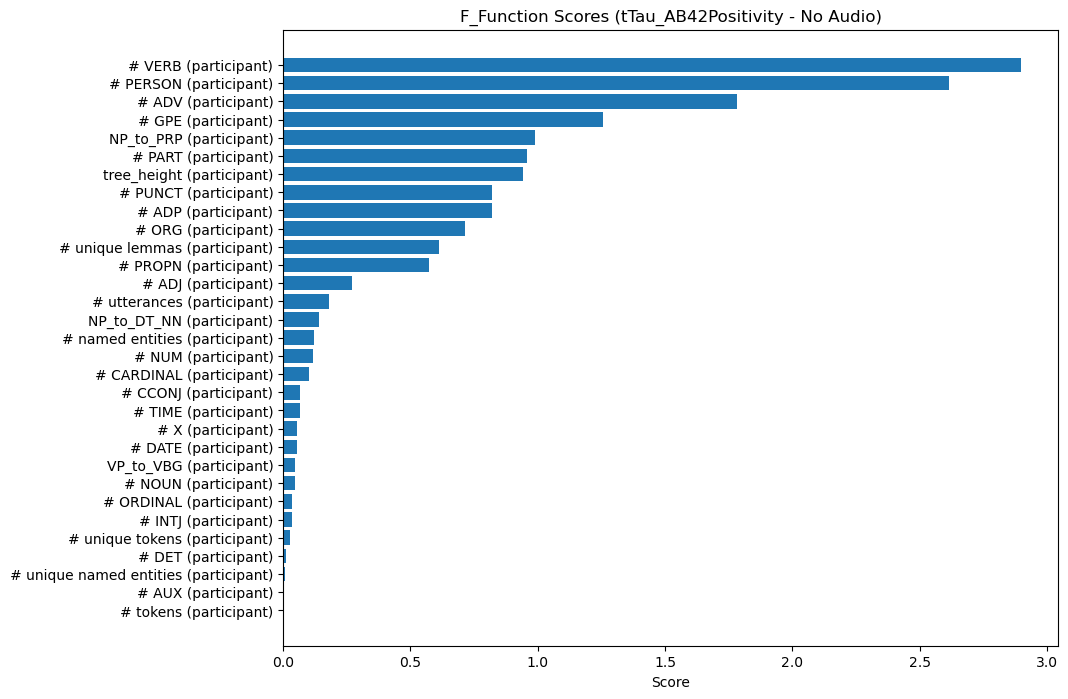

# VERB (participant), # PERSON (participant), # ADV (participant), # GPE (participant), NP_to_PRP (participant),
# PART (participant), tree_height (participant), # PUNCT (participant), # ADP (participant), # ORG (participant),
# unique lemmas (participant), # PROPN (participant), # ADJ (participant), # utterances (participant), NP_to_DT_NN (participant),
# named entities (participant), # NUM (participant), # CARDINAL (participant), # CCONJ (participant), # TIME (participant),
# X (participant), # DATE (participant), VP_to_VBG (participant), # NOUN (participant), # ORDINAL (participant),
# INTJ (participant), # unique tokens (participant), # DET (participant), # unique named entities (participant), # AUX (participant),
# tokens (participant)


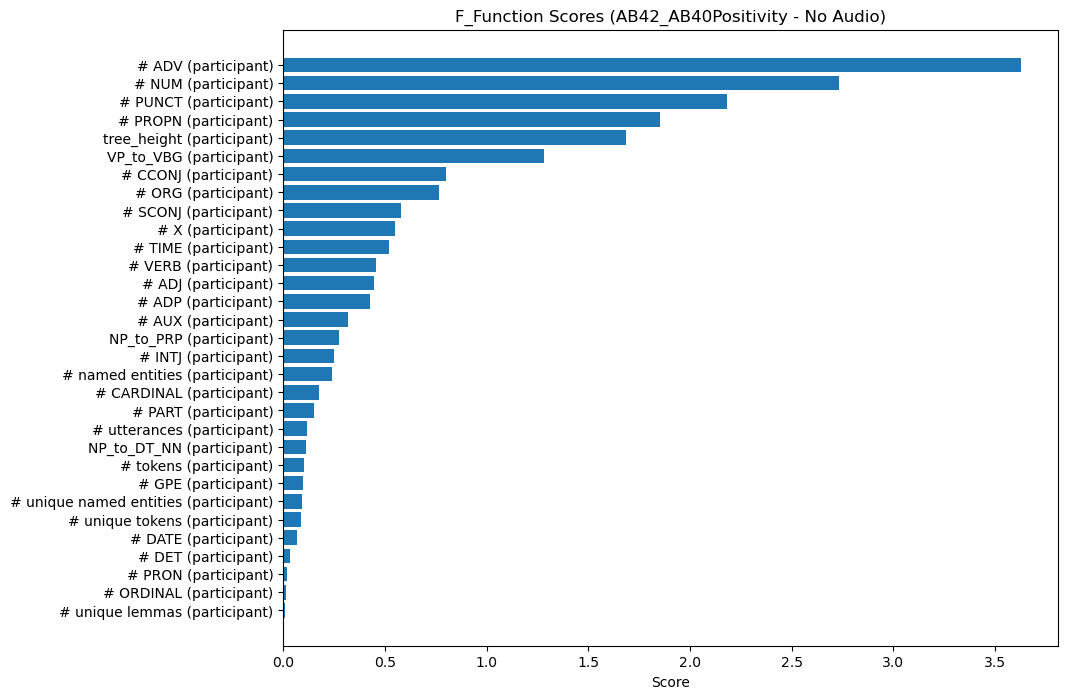

# ADV (participant), # NUM (participant), # PUNCT (participant), # PROPN (participant), tree_height (participant),
VP_to_VBG (participant), # CCONJ (participant), # ORG (participant), # SCONJ (participant), # X (participant),
# TIME (participant), # VERB (participant), # ADJ (participant), # ADP (participant), # AUX (participant),
NP_to_PRP (participant), # INTJ (participant), # named entities (participant), # CARDINAL (participant), # PART (participant),
# utterances (participant), NP_to_DT_NN (participant), # tokens (participant), # GPE (participant), # unique named entities (participant),
# unique tokens (participant), # DATE (participant), # DET (participant), # PRON (participant), # ORDINAL (participant),
# unique lemmas (participant)


In [14]:
MOCA_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('MOCA_impairment', audio=False)
TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('tTau_AB42Positivity', audio=False)
AB42_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('AB42_AB40Positivity', audio=False)

## Mutual Information

In [35]:
def m_info(to_predict, runs=1000, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(32).sort_values()
    for _ in range(runs):
        new_feat_importances = pd.Series(mutual_info_classif(X, y), cols)
        new_feat_importances = new_feat_importances.nlargest(32).sort_values()
        for col in new_feat_importances.index:
            if col not in feat_importances.index:
                feat_importances[col] = 0
            feat_importances[col] += new_feat_importances[col]
    feat_importances = feat_importances / runs
    feat_importances = feat_importances.nlargest(32).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print_feats(list(feat_importances.index)[::-1])
    return list(feat_importances.index[::-1])

### Full Data

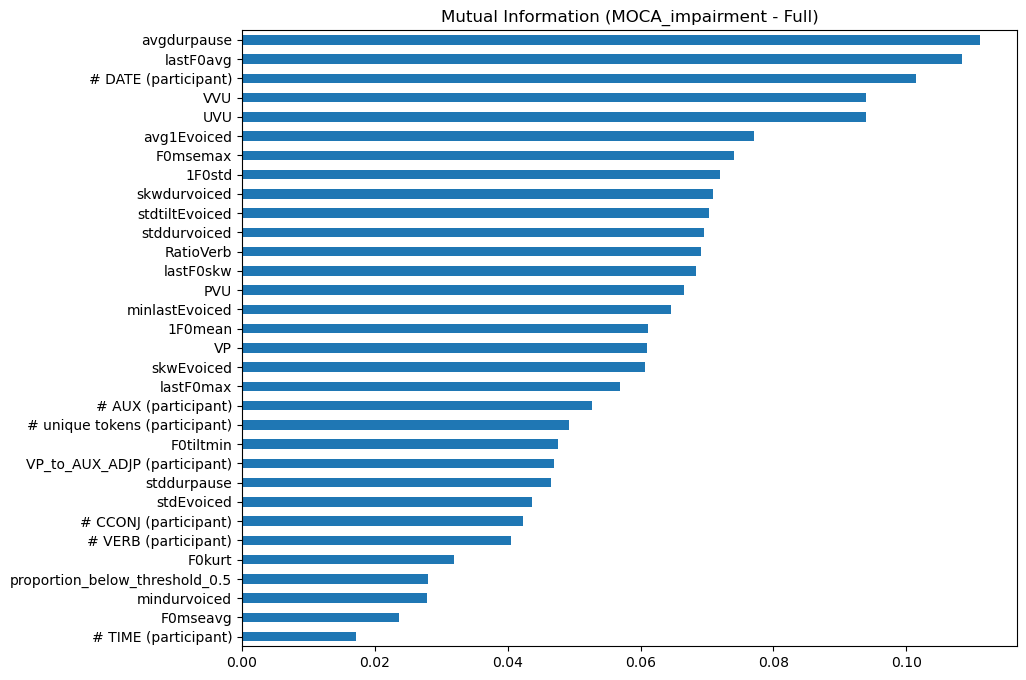

avgdurpause, lastF0avg, # DATE (participant), VVU, UVU,
avg1Evoiced, F0msemax, 1F0std, skwdurvoiced, stdtiltEvoiced,
stddurvoiced, RatioVerb, lastF0skw, PVU, minlastEvoiced,
1F0mean, VP, skwEvoiced, lastF0max, # AUX (participant),
# unique tokens (participant), F0tiltmin, VP_to_AUX_ADJP (participant), stddurpause, stdEvoiced,
# CCONJ (participant), # VERB (participant), F0kurt, proportion_below_threshold_0.5, mindurvoiced,
F0mseavg, # TIME (participant)


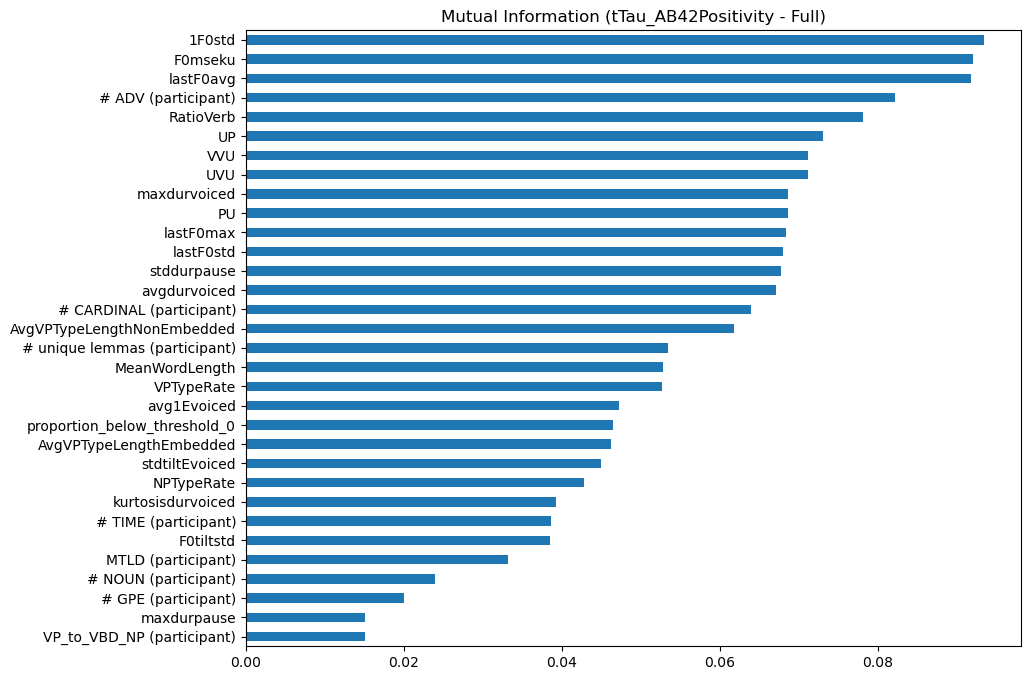

1F0std, F0mseku, lastF0avg, # ADV (participant), RatioVerb,
UP, VVU, UVU, maxdurvoiced, PU,
lastF0max, lastF0std, stddurpause, avgdurvoiced, # CARDINAL (participant),
AvgVPTypeLengthNonEmbedded, # unique lemmas (participant), MeanWordLength, VPTypeRate, avg1Evoiced,
proportion_below_threshold_0, AvgVPTypeLengthEmbedded, stdtiltEvoiced, NPTypeRate, kurtosisdurvoiced,
# TIME (participant), F0tiltstd, MTLD (participant), # NOUN (participant), # GPE (participant),
maxdurpause, VP_to_VBD_NP (participant)


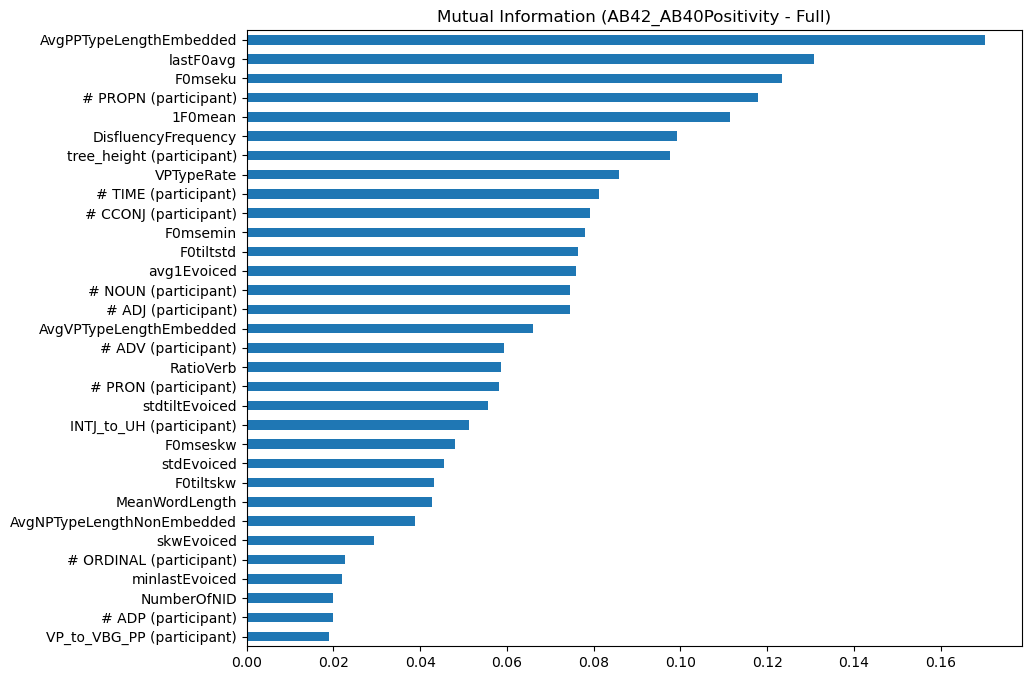

AvgPPTypeLengthEmbedded, lastF0avg, F0mseku, # PROPN (participant), 1F0mean,
DisfluencyFrequency, tree_height (participant), VPTypeRate, # TIME (participant), # CCONJ (participant),
F0msemin, F0tiltstd, avg1Evoiced, # NOUN (participant), # ADJ (participant),
AvgVPTypeLengthEmbedded, # ADV (participant), RatioVerb, # PRON (participant), stdtiltEvoiced,
INTJ_to_UH (participant), F0mseskw, stdEvoiced, F0tiltskw, MeanWordLength,
AvgNPTypeLengthNonEmbedded, skwEvoiced, # ORDINAL (participant), minlastEvoiced, NumberOfNID,
# ADP (participant), VP_to_VBG_PP (participant)


In [36]:
MOCA_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('MOCA_impairment')
TTAU_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('tTau_AB42Positivity')
AB42_MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('AB42_AB40Positivity')

### No Audio

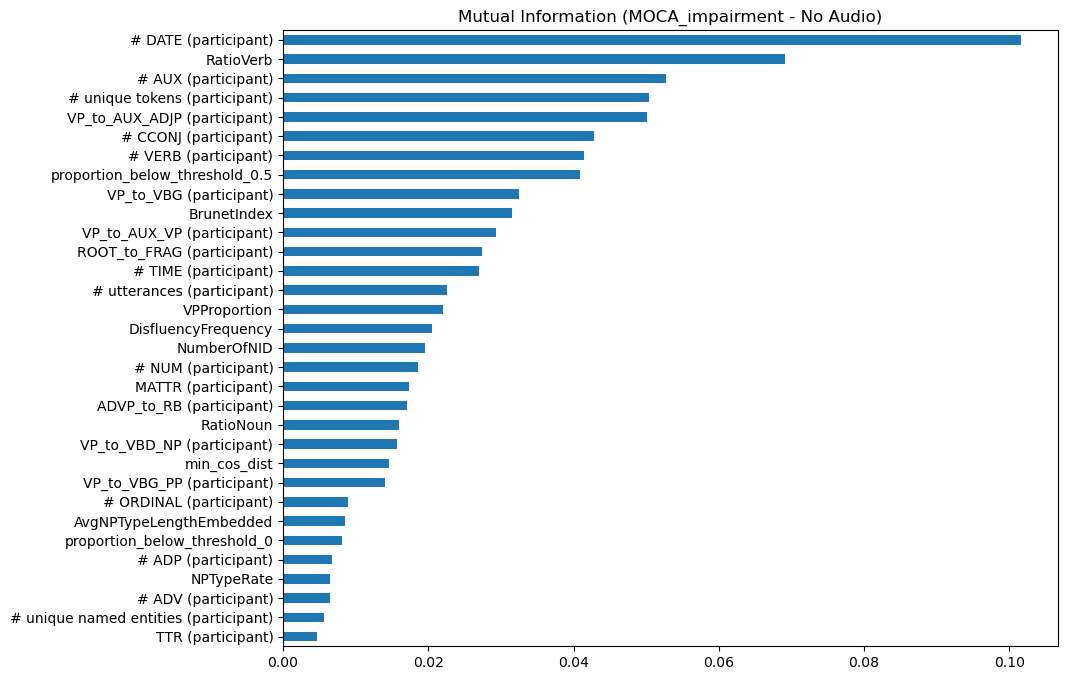

# DATE (participant), RatioVerb, # AUX (participant), # unique tokens (participant), VP_to_AUX_ADJP (participant),
# CCONJ (participant), # VERB (participant), proportion_below_threshold_0.5, VP_to_VBG (participant), BrunetIndex,
VP_to_AUX_VP (participant), ROOT_to_FRAG (participant), # TIME (participant), # utterances (participant), VPProportion,
DisfluencyFrequency, NumberOfNID, # NUM (participant), MATTR (participant), ADVP_to_RB (participant),
RatioNoun, VP_to_VBD_NP (participant), min_cos_dist, VP_to_VBG_PP (participant), # ORDINAL (participant),
AvgNPTypeLengthEmbedded, proportion_below_threshold_0, # ADP (participant), NPTypeRate, # ADV (participant),
# unique named entities (participant), TTR (participant)


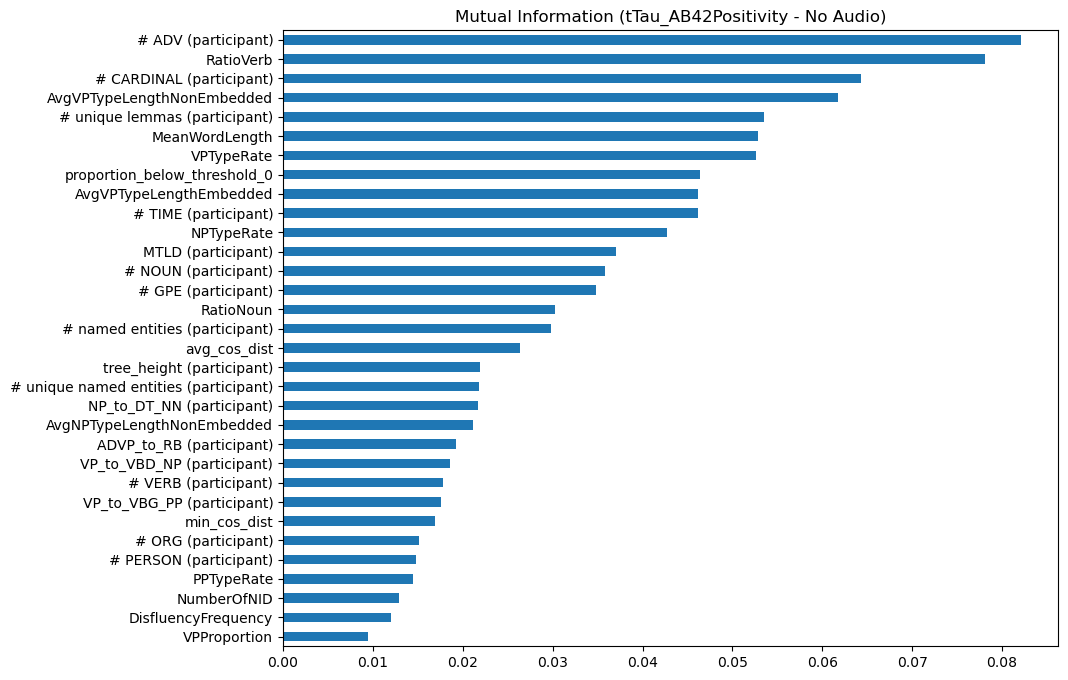

# ADV (participant), RatioVerb, # CARDINAL (participant), AvgVPTypeLengthNonEmbedded, # unique lemmas (participant),
MeanWordLength, VPTypeRate, proportion_below_threshold_0, AvgVPTypeLengthEmbedded, # TIME (participant),
NPTypeRate, MTLD (participant), # NOUN (participant), # GPE (participant), RatioNoun,
# named entities (participant), avg_cos_dist, tree_height (participant), # unique named entities (participant), NP_to_DT_NN (participant),
AvgNPTypeLengthNonEmbedded, ADVP_to_RB (participant), VP_to_VBD_NP (participant), # VERB (participant), VP_to_VBG_PP (participant),
min_cos_dist, # ORG (participant), # PERSON (participant), PPTypeRate, NumberOfNID,
DisfluencyFrequency, VPProportion


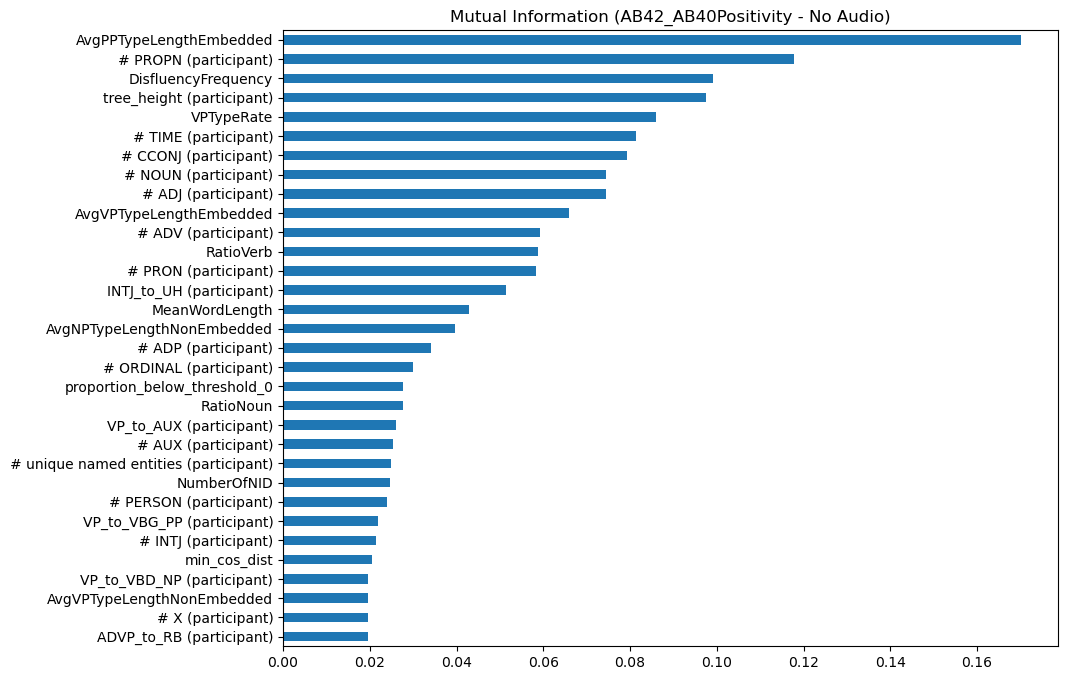

AvgPPTypeLengthEmbedded, # PROPN (participant), DisfluencyFrequency, tree_height (participant), VPTypeRate,
# TIME (participant), # CCONJ (participant), # NOUN (participant), # ADJ (participant), AvgVPTypeLengthEmbedded,
# ADV (participant), RatioVerb, # PRON (participant), INTJ_to_UH (participant), MeanWordLength,
AvgNPTypeLengthNonEmbedded, # ADP (participant), # ORDINAL (participant), proportion_below_threshold_0, RatioNoun,
VP_to_AUX (participant), # AUX (participant), # unique named entities (participant), NumberOfNID, # PERSON (participant),
VP_to_VBG_PP (participant), # INTJ (participant), min_cos_dist, VP_to_VBD_NP (participant), AvgVPTypeLengthNonEmbedded,
# X (participant), ADVP_to_RB (participant)


In [17]:
MOCA_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('MOCA_impairment', audio=False)
TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('tTau_AB42Positivity', audio=False)
AB42_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('AB42_AB40Positivity', audio=False)

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [37]:
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s, mean_rocs = [], [], []
    stdev_accs, stdev_f1s, stdev_rocs = [], [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s, rocs = [], [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            rocs.append(roc_auc_score(y_test, y_pred))

        mean_accs.append(round(np.mean(accs),4)), mean_f1s.append(round(np.mean(f1s),4)), mean_rocs.append(round(np.mean(rocs),4))
        stdev_accs.append(round(np.std(accs),4)), stdev_f1s.append(round(np.std(f1s),4)), stdev_rocs.append(round(np.std(rocs),4))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s), (mean_rocs, stdev_rocs)


In [38]:
def plot_metrics(accs, f1s, rocs, feats, _steps=STEPS):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(132)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(133)
    plt.title('Average ROC-AUC Score')
    plt.plot(x_axis, rocs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    for idx, step in enumerate(steps):
        print(f'**********   Top {step}   **********')
        print(f'Accuracy:       {accs[0][idx]} +- {accs[1][idx]}')
        print(f'F1 Score:       {f1s[0][idx]} +- {f1s[1][idx]}')
        print(f'ROC-AUC Score:  {rocs[0][idx]} +- {rocs[1][idx]}\n')

## Audio

In [40]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME)

X_moca_audio, y_moca_audio = load_raw_data(PATH, 'MOCA_impairment')
X_ttau_audio, y_ttau_audio = load_raw_data(PATH, 'tTau_AB42Positivity')
X_ab42_audio, y_ab42_audio = load_raw_data(PATH, 'AB42_AB40Positivity')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


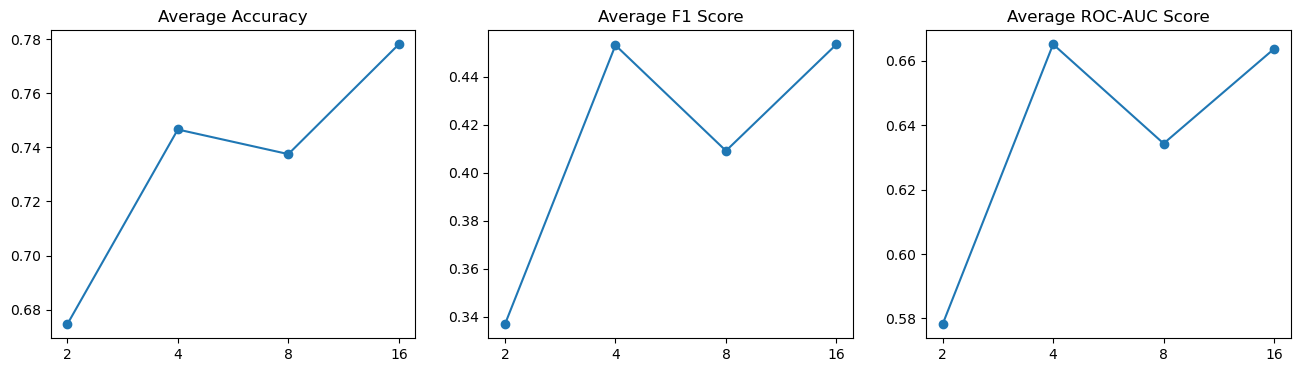

**********   Top 2   **********
Accuracy:       0.6746 +- 0.0959
F1 Score:       0.3369 +- 0.1766
ROC-AUC Score:  0.5782 +- 0.1222

**********   Top 4   **********
Accuracy:       0.7466 +- 0.0835
F1 Score:       0.4532 +- 0.1788
ROC-AUC Score:  0.6651 +- 0.1188

**********   Top 8   **********
Accuracy:       0.7375 +- 0.0875
F1 Score:       0.4092 +- 0.1925
ROC-AUC Score:  0.6343 +- 0.1232

**********   Top 16   **********
Accuracy:       0.7781 +- 0.0801
F1 Score:       0.4536 +- 0.2038
ROC-AUC Score:  0.6637 +- 0.12



In [42]:
moca_ml_audio_feats = MOCA_ML_FULL_COMPUTED_FEATURES[:]
moca_ml_accs, moca_ml_f1s, moca_ml_rocs = check_top_features(X_moca_audio, y_moca_audio, moca_ml_audio_feats)
plot_metrics(moca_ml_accs, moca_ml_f1s, moca_ml_rocs, moca_ml_audio_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


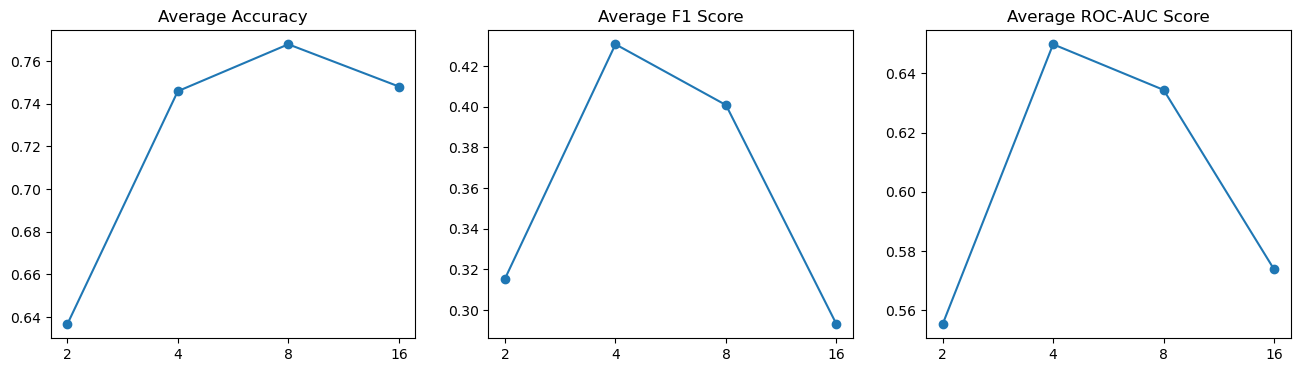

**********   Top 2   **********
Accuracy:       0.6366 +- 0.1029
F1 Score:       0.3154 +- 0.1671
ROC-AUC Score:  0.5553 +- 0.1249

**********   Top 4   **********
Accuracy:       0.7459 +- 0.0878
F1 Score:       0.4308 +- 0.1921
ROC-AUC Score:  0.6498 +- 0.1242

**********   Top 8   **********
Accuracy:       0.7679 +- 0.0764
F1 Score:       0.4009 +- 0.2123
ROC-AUC Score:  0.6344 +- 0.121

**********   Top 16   **********
Accuracy:       0.7481 +- 0.0763
F1 Score:       0.293 +- 0.2099
ROC-AUC Score:  0.5738 +- 0.1076



In [43]:
moca_f_classif_feats_audio = MOCA_F_CLASSIF_FULL_COMPUTED_FEATURES[:]

moca_f_classif_accs_audio, moca_f_classif_f1s_audio, moca_f_classif_rocs_audio = check_top_features(X_moca_audio, y_moca_audio, moca_f_classif_feats_audio)
plot_metrics(moca_f_classif_accs_audio, moca_f_classif_f1s_audio, moca_f_classif_rocs_audio, moca_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:00<00:00,  3.32it/s]


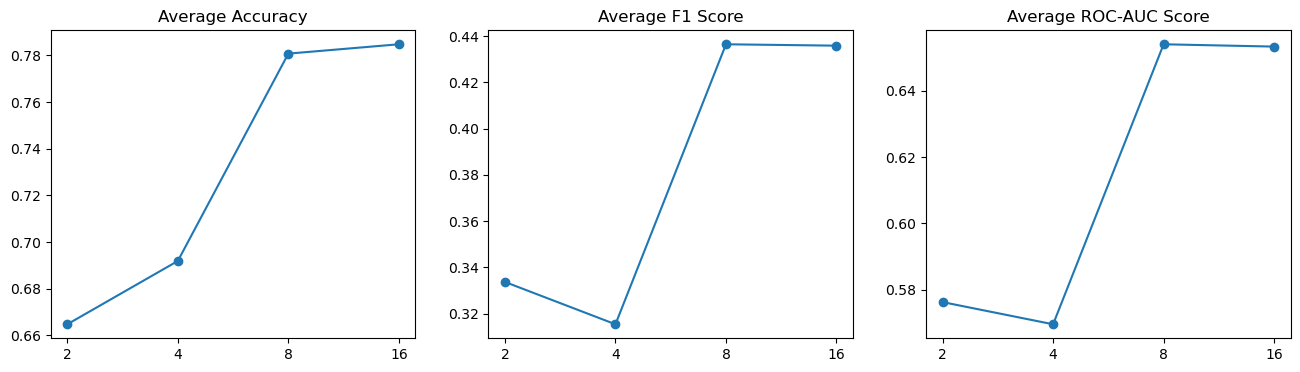

**********   Top 2   **********
Accuracy:       0.6648 +- 0.0973
F1 Score:       0.3337 +- 0.1757
ROC-AUC Score:  0.5762 +- 0.1236

**********   Top 4   **********
Accuracy:       0.6919 +- 0.0874
F1 Score:       0.3154 +- 0.1803
ROC-AUC Score:  0.5695 +- 0.117

**********   Top 8   **********
Accuracy:       0.7807 +- 0.0781
F1 Score:       0.4365 +- 0.2118
ROC-AUC Score:  0.6541 +- 0.1207

**********   Top 16   **********
Accuracy:       0.7847 +- 0.0744
F1 Score:       0.4359 +- 0.204
ROC-AUC Score:  0.6534 +- 0.1157



In [44]:
moca_mutual_info_feats_audio = MOCA_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

moca_mutual_info_accs_audio, moca_mutual_info_f1s_audio, moca_mutual_info_rocs_audio = check_top_features(X_moca_audio, y_moca_audio, moca_mutual_info_feats_audio)
plot_metrics(moca_mutual_info_accs_audio, moca_mutual_info_f1s_audio, moca_mutual_info_rocs_audio, moca_mutual_info_feats_audio)

### tTau_AB42Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


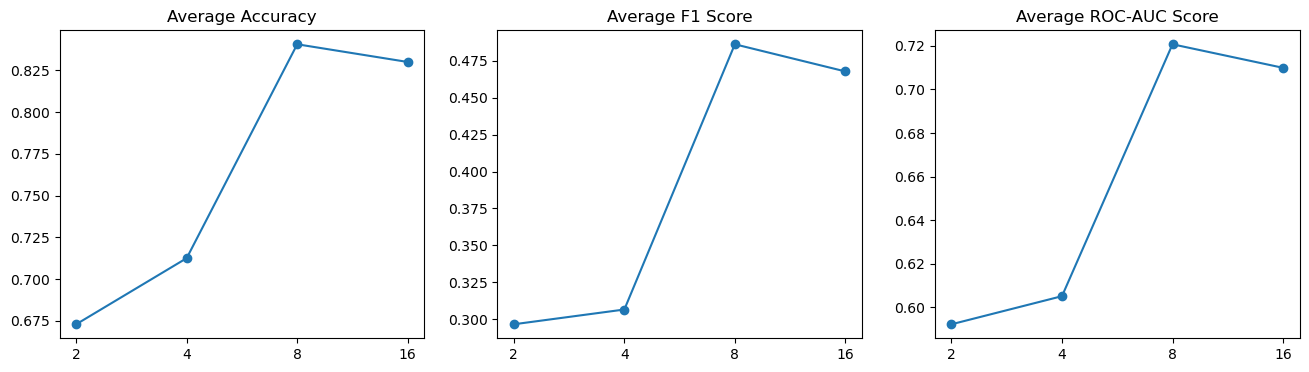

**********   Top 2   **********
Accuracy:       0.6729 +- 0.1215
F1 Score:       0.2965 +- 0.2082
ROC-AUC Score:  0.5922 +- 0.1697

**********   Top 4   **********
Accuracy:       0.7125 +- 0.1102
F1 Score:       0.3065 +- 0.2288
ROC-AUC Score:  0.6051 +- 0.1703

**********   Top 8   **********
Accuracy:       0.8406 +- 0.0907
F1 Score:       0.4862 +- 0.2953
ROC-AUC Score:  0.7207 +- 0.1752

**********   Top 16   **********
Accuracy:       0.83 +- 0.0888
F1 Score:       0.4678 +- 0.2852
ROC-AUC Score:  0.7099 +- 0.1749



In [45]:
ttau_ml_feats_audio = TTAU_ML_FULL_COMPUTED_FEATURES[:]

ttau_ml_accs_audio, ttau_ml_f1s_audio, ttau_ml_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_ml_feats_audio)
plot_metrics(ttau_ml_accs_audio, ttau_ml_f1s_audio, ttau_ml_rocs_audio, ttau_ml_feats_audio)

In [77]:
TTAU_ML_FULL_COMPUTED_FEATURES[:8]

['PU',
 'UP',
 'VP',
 'PVU',
 'maxdurpause',
 'stddurpause',
 '1F0std',
 'avgdurvoiced']

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


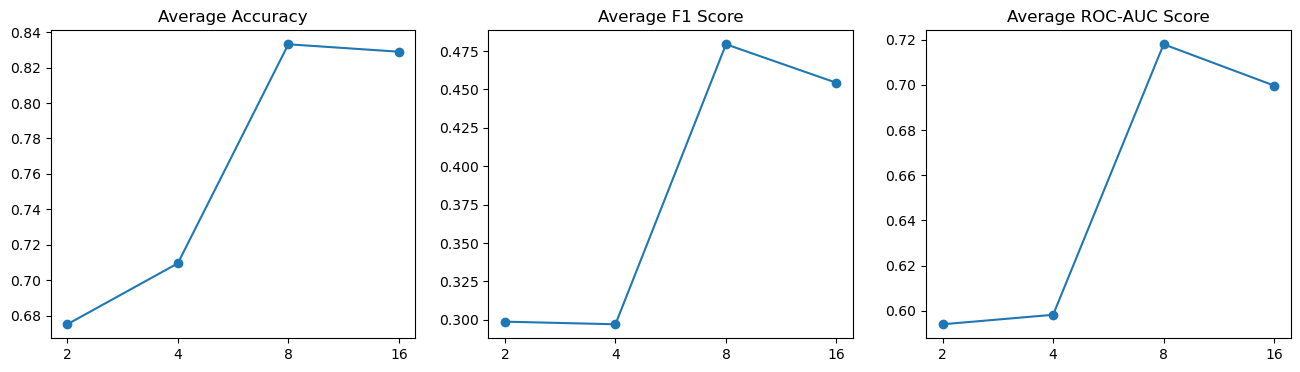

**********   Top 2   **********
Accuracy:       0.6751 +- 0.1195
F1 Score:       0.2988 +- 0.208
ROC-AUC Score:  0.594 +- 0.1697

**********   Top 4   **********
Accuracy:       0.7095 +- 0.1052
F1 Score:       0.2971 +- 0.2232
ROC-AUC Score:  0.5982 +- 0.1665

**********   Top 8   **********
Accuracy:       0.8332 +- 0.093
F1 Score:       0.4794 +- 0.2938
ROC-AUC Score:  0.718 +- 0.1789

**********   Top 16   **********
Accuracy:       0.829 +- 0.0922
F1 Score:       0.4543 +- 0.29
ROC-AUC Score:  0.6997 +- 0.1724



In [46]:
ttau_f_classif_feats_audio = TTAU_F_CLASSIF_FULL_COMPUTED_FEATURES[:]

ttau_f_classif_accs_audio, ttau_f_classif_f1s_audio, ttau_f_classif_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_ml_feats_audio)
plot_metrics(ttau_f_classif_accs_audio, ttau_f_classif_f1s_audio, ttau_f_classif_rocs_audio, ttau_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


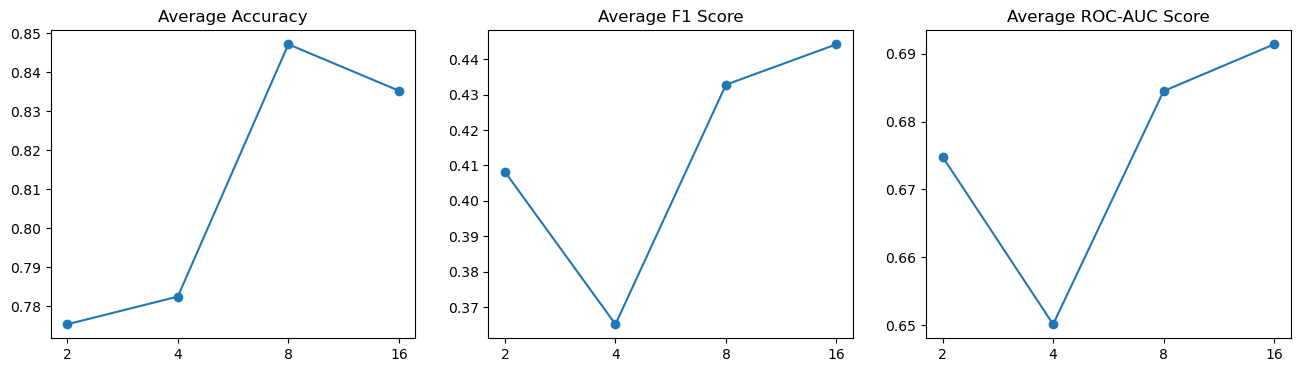

**********   Top 2   **********
Accuracy:       0.7754 +- 0.1081
F1 Score:       0.4082 +- 0.2573
ROC-AUC Score:  0.6748 +- 0.1739

**********   Top 4   **********
Accuracy:       0.7825 +- 0.1033
F1 Score:       0.3652 +- 0.2809
ROC-AUC Score:  0.6501 +- 0.1797

**********   Top 8   **********
Accuracy:       0.8472 +- 0.0842
F1 Score:       0.4328 +- 0.3204
ROC-AUC Score:  0.6845 +- 0.1756

**********   Top 16   **********
Accuracy:       0.8353 +- 0.0867
F1 Score:       0.4442 +- 0.2953
ROC-AUC Score:  0.6914 +- 0.1705



In [47]:
ttau_mutual_info_feats_audio = TTAU_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

ttau_mutual_info_accs_audio, ttau_mutual_info_f1s_audio, ttau_mutual_info_rocs_audio = check_top_features(X_ttau_audio, y_ttau_audio, ttau_mutual_info_feats_audio)
plot_metrics(ttau_mutual_info_accs_audio, ttau_mutual_info_f1s_audio, ttau_mutual_info_rocs_audio, ttau_mutual_info_feats_audio)

### AB42_AB40Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:27<00:00,  4.83it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:45<00:00,  3.51it/s]


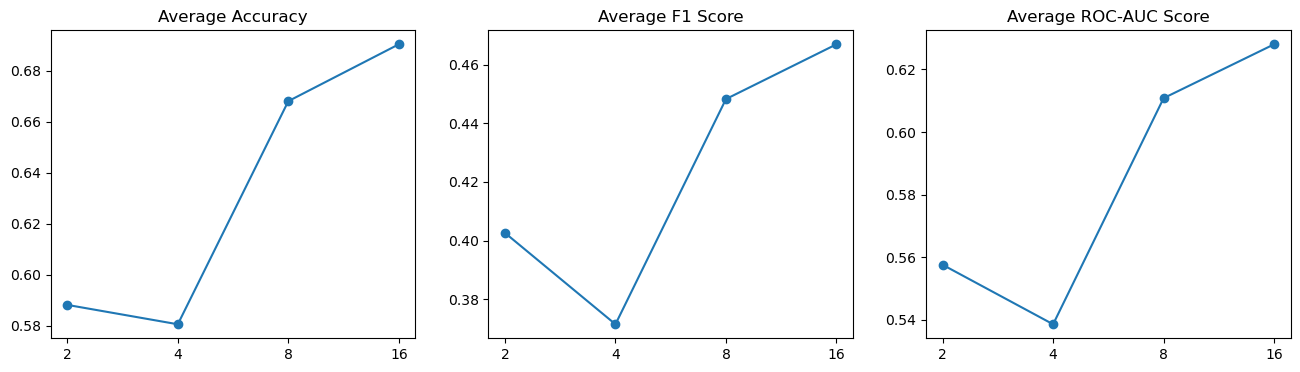

**********   Top 2   **********
Accuracy:       0.5882 +- 0.1215
F1 Score:       0.4026 +- 0.1849
ROC-AUC Score:  0.5576 +- 0.1354

**********   Top 4   **********
Accuracy:       0.5806 +- 0.1182
F1 Score:       0.3714 +- 0.1803
ROC-AUC Score:  0.5386 +- 0.1277

**********   Top 8   **********
Accuracy:       0.6681 +- 0.1182
F1 Score:       0.4483 +- 0.1987
ROC-AUC Score:  0.6108 +- 0.1318

**********   Top 16   **********
Accuracy:       0.6904 +- 0.1159
F1 Score:       0.467 +- 0.2048
ROC-AUC Score:  0.628 +- 0.1288



In [48]:
ab42_ml_feats_audio = AB42_ML_FULL_COMPUTED_FEATURES[:]

ab42_ml_accs_audio, ab42_ml_f1s_audio, ab42_ml_rocs_audio = check_top_features(X_ab42_audio, y_ab42_audio, ab42_ml_feats_audio)
plot_metrics(ab42_ml_accs_audio, ab42_ml_f1s_audio, ab42_ml_rocs_audio, ab42_ml_feats_audio)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:32<00:00,  4.72it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


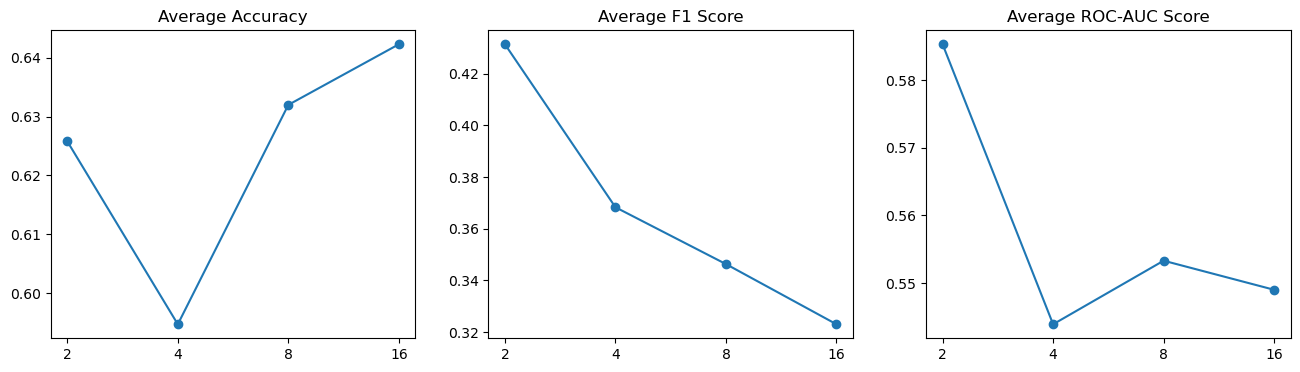

**********   Top 2   **********
Accuracy:       0.6258 +- 0.1261
F1 Score:       0.4314 +- 0.1825
ROC-AUC Score:  0.5853 +- 0.1315

**********   Top 4   **********
Accuracy:       0.5947 +- 0.1163
F1 Score:       0.3683 +- 0.1873
ROC-AUC Score:  0.5439 +- 0.1253

**********   Top 8   **********
Accuracy:       0.632 +- 0.105
F1 Score:       0.3463 +- 0.2047
ROC-AUC Score:  0.5533 +- 0.1195

**********   Top 16   **********
Accuracy:       0.6423 +- 0.1095
F1 Score:       0.323 +- 0.2141
ROC-AUC Score:  0.549 +- 0.1215



In [49]:
ab42_f_classif_feats_audio = AB42_F_CLASSIF_FULL_COMPUTED_FEATURES[:]


ab42_f_classif_accs_audio, ab42_f_classif_f1s_audio, ab42_f_classif_rocs_audio = check_top_features(X_ab42_audio, y_ab42_audio, ab42_f_classif_feats_audio)
plot_metrics(ab42_f_classif_accs_audio, ab42_f_classif_f1s_audio, ab42_f_classif_rocs_audio, ab42_f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.74it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:43<00:00,  3.52it/s]


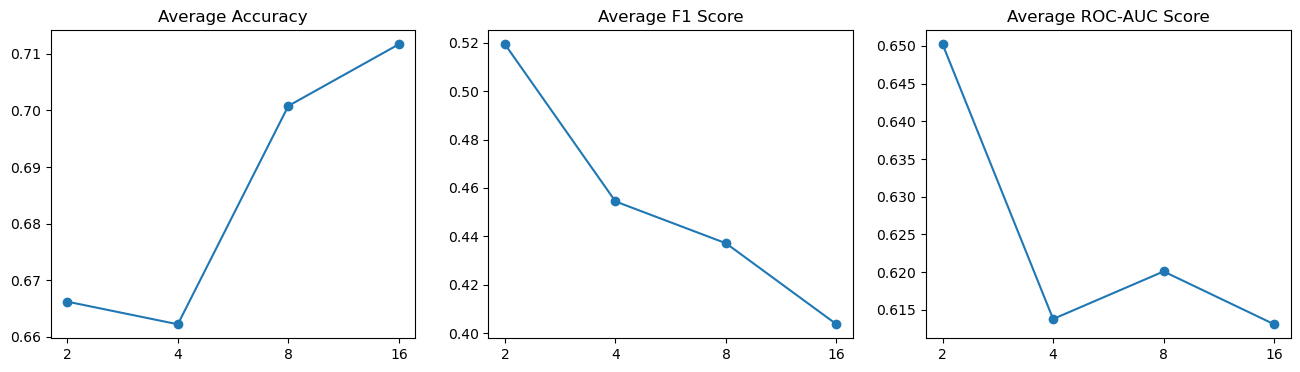

**********   Top 2   **********
Accuracy:       0.6662 +- 0.123
F1 Score:       0.5194 +- 0.186
ROC-AUC Score:  0.6502 +- 0.1369

**********   Top 4   **********
Accuracy:       0.6622 +- 0.1163
F1 Score:       0.4544 +- 0.2018
ROC-AUC Score:  0.6138 +- 0.1341

**********   Top 8   **********
Accuracy:       0.7008 +- 0.1082
F1 Score:       0.4371 +- 0.2225
ROC-AUC Score:  0.6201 +- 0.1282

**********   Top 16   **********
Accuracy:       0.7117 +- 0.1055
F1 Score:       0.4036 +- 0.2458
ROC-AUC Score:  0.6131 +- 0.1289



In [50]:
ab42_mutual_info_feats_audio = AB42_MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

ab42_mutual_info_accs_audio, ab42_mutual_info_f1s_audio, ab42_mutual_info_rocs_audio = check_top_features(X_ab42_audio, y_ab42_audio, ab42_mutual_info_feats_audio)
plot_metrics(ab42_mutual_info_accs_audio, ab42_mutual_info_f1s_audio, ab42_mutual_info_rocs_audio, ab42_mutual_info_feats_audio)

## No Audio

In [10]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)

X_moca, y_moca = load_raw_data(PATH, 'MOCA_impairment')
X_ttau, y_ttau = load_raw_data(PATH, 'tTau_AB42Positivity')
X_ab42, y_ab42 = load_raw_data(PATH, 'AB42_AB40Positivity')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


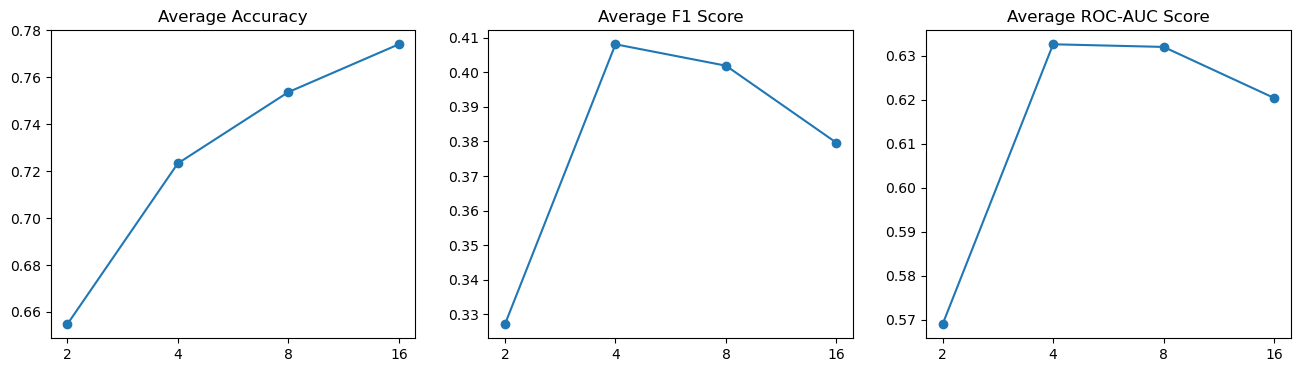

**********   Top 2   **********
Accuracy:       0.6547 +- 0.0972
F1 Score:       0.3271 +- 0.1722
ROC-AUC Score:  0.569 +- 0.1233

**********   Top 4   **********
Accuracy:       0.7233 +- 0.0933
F1 Score:       0.4081 +- 0.1921
ROC-AUC Score:  0.6326 +- 0.1278

**********   Top 8   **********
Accuracy:       0.7537 +- 0.0825
F1 Score:       0.4019 +- 0.2043
ROC-AUC Score:  0.632 +- 0.121

**********   Top 16   **********
Accuracy:       0.7741 +- 0.076
F1 Score:       0.3796 +- 0.2118
ROC-AUC Score:  0.6204 +- 0.1124



In [26]:
moca_ml_feats = [#MOCA_ML_NO_AUDIO_COMPUTED_FEATURES[:]
    '# unique tokens (participant)', '# unique lemmas (participant)', '# tokens (participant)', '# DATE (participant)', 'HonoreStatistic',
    '# utterances (participant)', 'NPTypeRate', 'TTR (participant)', 'RatioPronoun', 'MATTR (participant)',
    'VP_to_VBG (participant)', '# VERB (participant)', 'VP_to_AUX_ADJP (participant)', '# AUX (participant)', '# named entities (participant)',
    'AvgNPTypeLengthNonEmbedded', 'VPProportion', 'proportion_below_threshold_0.5', 'MSTTR (participant)', 'NP_to_DT_NN (participant)',
    'AvgPPTypeLengthEmbedded', 'AvgVPTypeLengthEmbedded', '# PUNCT (participant)', 'MTLD (participant)', '# unique named entities (participant)',
    '# GPE (participant)', 'AvgVPTypeLengthNonEmbedded', 'proportion_below_threshold_0', '# DET (participant)', '# ORDINAL (participant)'
]
moca_ml_accs, moca_ml_f1s, moca_ml_rocs = check_top_features(X_moca, y_moca, moca_ml_feats)
plot_metrics(moca_ml_accs, moca_ml_f1s, moca_ml_rocs, moca_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


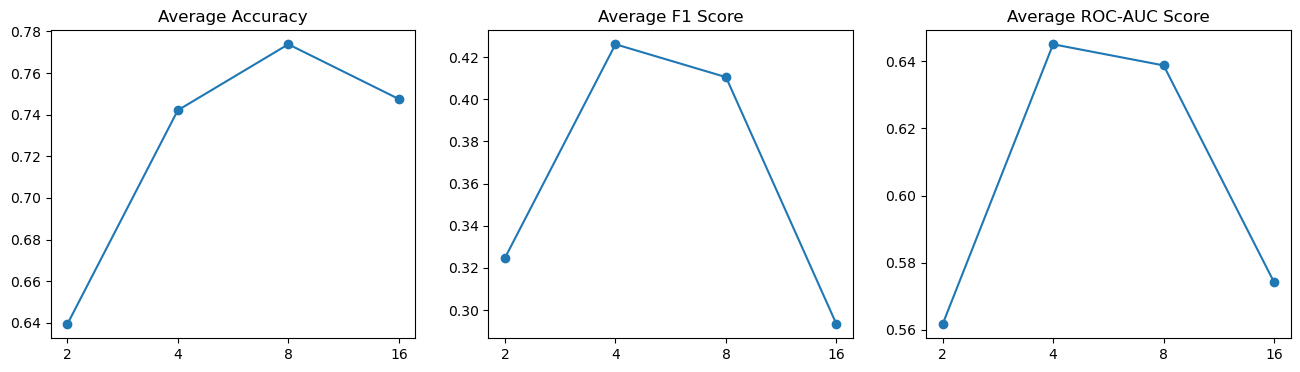

**********   Top 2   **********
Accuracy:       0.6393 +- 0.1088
F1 Score:       0.3247 +- 0.172
ROC-AUC Score:  0.5616 +- 0.1294

**********   Top 4   **********
Accuracy:       0.7421 +- 0.0869
F1 Score:       0.4261 +- 0.1895
ROC-AUC Score:  0.6451 +- 0.1242

**********   Top 8   **********
Accuracy:       0.7738 +- 0.0765
F1 Score:       0.4105 +- 0.2093
ROC-AUC Score:  0.6388 +- 0.1183

**********   Top 16   **********
Accuracy:       0.7475 +- 0.0779
F1 Score:       0.2932 +- 0.2103
ROC-AUC Score:  0.5741 +- 0.1084



In [27]:
moca_f_classif_feats = [
    '# tokens (participant)', '# unique tokens (participant)', 'VP_to_VBG (participant)', '# DATE (participant)', '# named entities (participant)',
    '# utterances (participant)', '# AUX (participant)', '# CARDINAL (participant)', '# unique named entities (participant)', '# VERB (participant)',
    '# PUNCT (participant)', '# SCONJ (participant)', '# PART (participant)', 'tree_height (participant)', '# PROPN (participant)',
    'NP_to_DT_NN (participant)', '# ORDINAL (participant)', '# NOUN (participant)', '# ORG (participant)', '# NUM (participant)',
    '# unique lemmas (participant)', '# ADP (participant)', '# DET (participant)', '# CCONJ (participant)', '# X (participant)',
    '# ADJ (participant)', '# GPE (participant)', '# ADV (participant)', '# TIME (participant)', 'NP_to_PRP (participant)',
    '# PRON (participant)'
]#MOCA_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

moca_f_classif_accs, moca_f_classif_f1s, moca_f_classif_rocs = check_top_features(X_moca, y_moca, moca_f_classif_feats)
plot_metrics(moca_f_classif_accs, moca_f_classif_f1s, moca_f_classif_rocs, moca_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


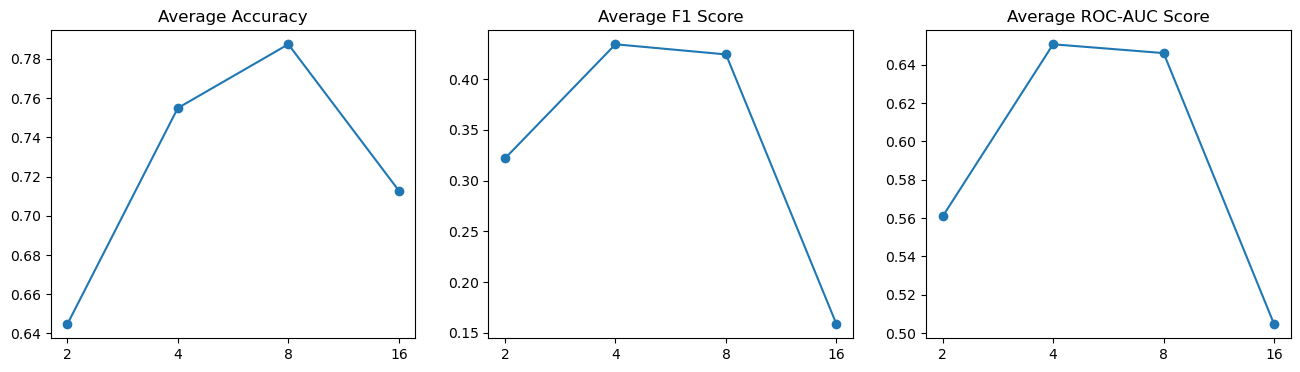

**********   Top 2   **********
Accuracy:       0.6447 +- 0.1045
F1 Score:       0.3218 +- 0.1696
ROC-AUC Score:  0.5608 +- 0.1264

**********   Top 4   **********
Accuracy:       0.7549 +- 0.0863
F1 Score:       0.4343 +- 0.1945
ROC-AUC Score:  0.6506 +- 0.1205

**********   Top 8   **********
Accuracy:       0.7874 +- 0.0798
F1 Score:       0.4243 +- 0.2216
ROC-AUC Score:  0.646 +- 0.1211

**********   Top 16   **********
Accuracy:       0.7128 +- 0.0781
F1 Score:       0.1584 +- 0.1832
ROC-AUC Score:  0.5046 +- 0.0925



In [28]:
moca_mutual_info_feats = [
    '# DATE (participant)', 'RatioVerb', '# AUX (participant)', '# unique tokens (participant)', 'VP_to_AUX_ADJP (participant)',
    '# CCONJ (participant)', '# VERB (participant)', 'proportion_below_threshold_0.5', 'VP_to_VBG (participant)', 'BrunetIndex',
    'VP_to_AUX_VP (participant)', 'ROOT_to_FRAG (participant)', '# TIME (participant)', '# utterances (participant)', 'VPProportion',
    'DisfluencyFrequency', 'NumberOfNID', '# NUM (participant)', 'MATTR (participant)', 'ADVP_to_RB (participant)',
    'RatioNoun', 'VP_to_VBD_NP (participant)', 'min_cos_dist', 'VP_to_VBG_PP (participant)', '# ORDINAL (participant)',
    'AvgNPTypeLengthEmbedded', 'proportion_below_threshold_0', '# ADP (participant)', 'NPTypeRate', '# ADV (participant)',
    '# unique named entities (participant)', 'TTR (participant)'
]#MOCA_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

moca_mutual_info_accs, moca_mutual_info_f1s, moca_mutual_info_rocs = check_top_features(X_moca, y_moca, moca_mutual_info_feats)
plot_metrics(moca_mutual_info_accs, moca_mutual_info_f1s, moca_mutual_info_rocs, moca_mutual_info_feats)

#### Mixed Sets

In [29]:
moca_top_features = []
a, b = moca_ml_feats[:16], moca_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in moca_top_features:
            moca_top_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in moca_top_features:
            moca_top_features.append(b[idx])

moca_top_accs, moca_top_f1s, moca_top_rocs = check_top_features(X_moca, y_moca, moca_top_features, [2,4,8,16,18])


Checking top 2 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]



Checking top 17 features


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


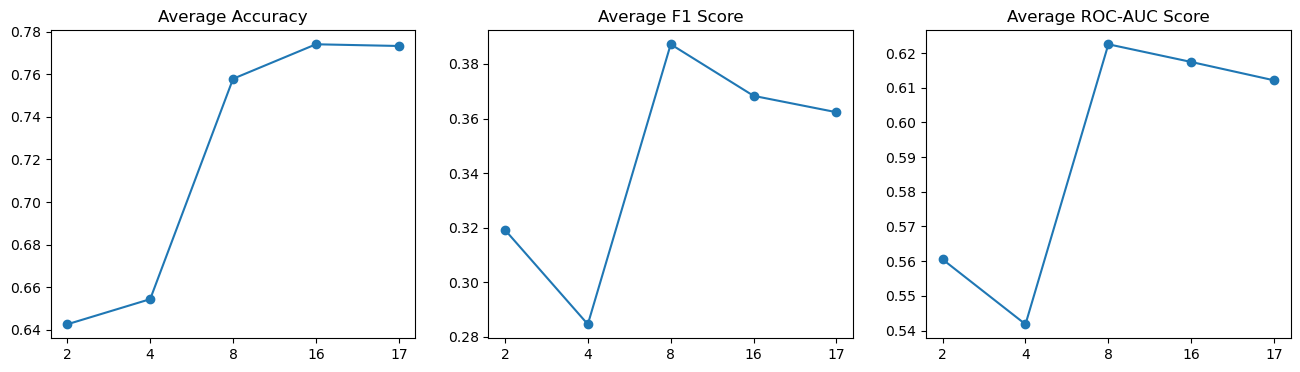

**********   Top 2   **********
Accuracy:       0.6426 +- 0.101
F1 Score:       0.3192 +- 0.1661
ROC-AUC Score:  0.5605 +- 0.1237

**********   Top 4   **********
Accuracy:       0.6544 +- 0.0989
F1 Score:       0.2846 +- 0.174
ROC-AUC Score:  0.5418 +- 0.1188

**********   Top 8   **********
Accuracy:       0.7579 +- 0.0831
F1 Score:       0.3872 +- 0.2071
ROC-AUC Score:  0.6225 +- 0.1181

**********   Top 16   **********
Accuracy:       0.7741 +- 0.0742
F1 Score:       0.3683 +- 0.2203
ROC-AUC Score:  0.6174 +- 0.1143

**********   Top 17   **********
Accuracy:       0.7733 +- 0.0748
F1 Score:       0.3623 +- 0.2138
ROC-AUC Score:  0.6121 +- 0.1124



In [30]:
plot_metrics(moca_top_accs, moca_top_f1s, moca_top_rocs, moca_top_features, [2,4,8,16,24])

### MOCA_impairment final results

We have obtained a clear "winner" for this task, in particular the `top 8` from the `statistical approach (mutual information)`.</br>
In particular we have achieved an `accuracy of 0.7913 +- 0.0751` and an `F1 score of 0.4369 +- 0.2055`.

The best features are:
1. `# DATE (participant)`
2. `RatioVerb`
3. `# AUX (participant)`
4. `# unique tokens (participant)`
5. `VP_to_AUX_ADJP (participant)`
6. `# CCONJ (participant)`
7. `# VERB (participant)`
8. `proportion_below_threshold_0.5`

******************************************************************************************************************************************
******************************************************************************************************************************************

### tTau_AB42Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [04:01<00:00,  4.15it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


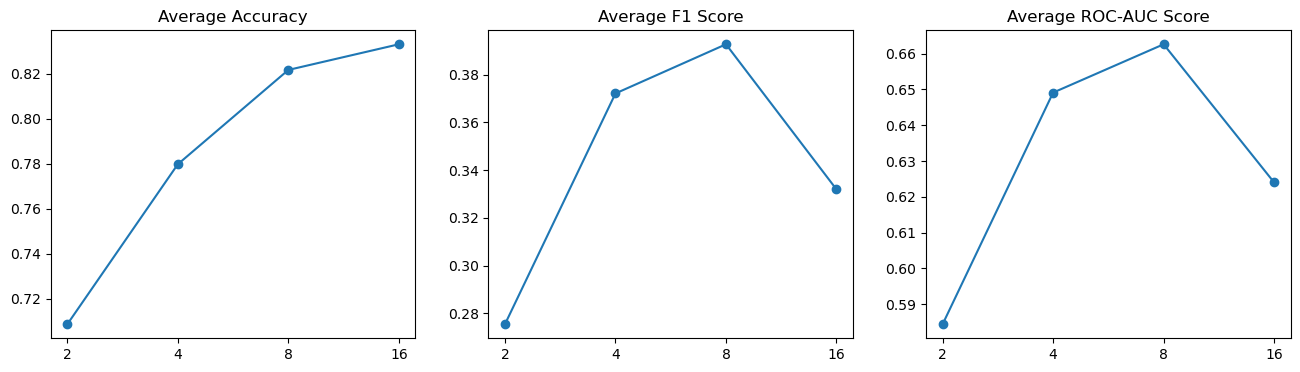

**********   Top 2   **********
Accuracy:       0.7086 +- 0.1107
F1 Score:       0.2754 +- 0.23
ROC-AUC Score:  0.5844 +- 0.1663

**********   Top 4   **********
Accuracy:       0.7797 +- 0.0996
F1 Score:       0.3721 +- 0.2618
ROC-AUC Score:  0.6491 +- 0.1674

**********   Top 8   **********
Accuracy:       0.8216 +- 0.0896
F1 Score:       0.3927 +- 0.2986
ROC-AUC Score:  0.6626 +- 0.1697

**********   Top 16   **********
Accuracy:       0.833 +- 0.0808
F1 Score:       0.3319 +- 0.3153
ROC-AUC Score:  0.624 +- 0.1606



In [31]:
ttau_ml_feats = [
    'MATTR (participant)', 'VP_to_AUX_VP (participant)', '# TIME (participant)', 'RatioNoun', 'RatioVerb',
    'tree_height (participant)', 'BrunetIndex', 'AvgNPTypeLengthNonEmbedded', 'AvgVPTypeLengthEmbedded', 'PPTypeRate',
    'VPProportion', 'VPTypeRate', 'TTR (participant)', '# ADP (participant)', '# NOUN (participant)',
    'proportion_below_threshold_0.3', '# VERB (participant)', '# ADV (participant)', 'MTLD (participant)', 'VP_to_AUX (participant)',
    'HonoreStatistic', 'proportion_below_threshold_0.5', 'proportion_below_threshold_0', '# utterances (participant)', '# ORDINAL (participant)',
    'ROOT_to_FRAG (participant)', '# GPE (participant)', 'INTJ_to_UH (participant)', 'NPTypeRate', '# unique lemmas (participant)',
]#TTAU_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_ml_accs, ttau_ml_f1s, ttau_ml_rocs = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_metrics(ttau_ml_accs, ttau_ml_f1s, ttau_ml_rocs, ttau_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [04:00<00:00,  4.15it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:06<00:00,  4.06it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


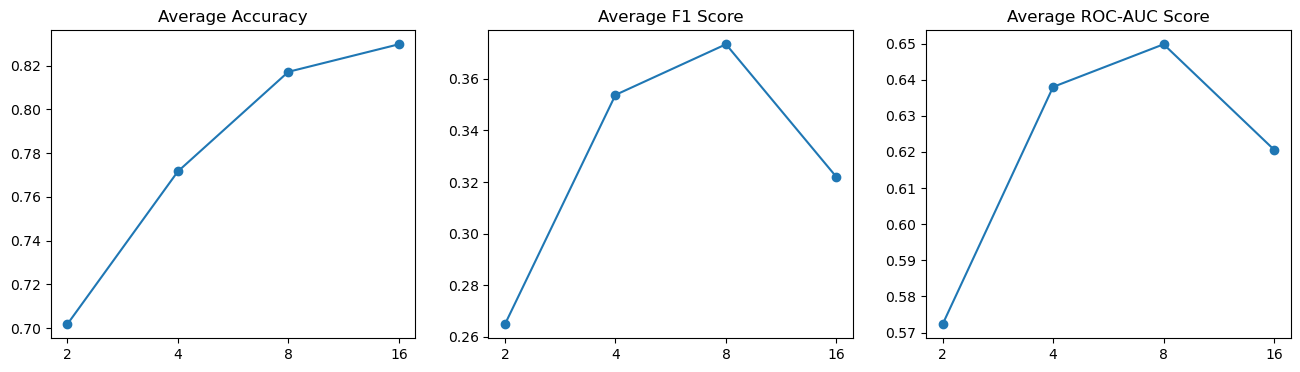

**********   Top 2   **********
Accuracy:       0.7017 +- 0.1136
F1 Score:       0.2649 +- 0.2286
ROC-AUC Score:  0.5723 +- 0.1676

**********   Top 4   **********
Accuracy:       0.7716 +- 0.1025
F1 Score:       0.3537 +- 0.2603
ROC-AUC Score:  0.638 +- 0.1674

**********   Top 8   **********
Accuracy:       0.8172 +- 0.0908
F1 Score:       0.3733 +- 0.3024
ROC-AUC Score:  0.6498 +- 0.1722

**********   Top 16   **********
Accuracy:       0.8298 +- 0.0829
F1 Score:       0.3219 +- 0.3163
ROC-AUC Score:  0.6206 +- 0.1637



In [32]:
ttau_f_classif_feats = [
    '# VERB (participant)', '# PERSON (participant)', '# ADV (participant)', '# GPE (participant)', 'NP_to_PRP (participant)',
    '# PART (participant)', 'tree_height (participant)', '# PUNCT (participant)', '# ADP (participant)', '# ORG (participant)',
    '# unique lemmas (participant)', '# PROPN (participant)', '# ADJ (participant)', '# utterances (participant)', 'NP_to_DT_NN (participant)',
    '# named entities (participant)', '# NUM (participant)', '# CARDINAL (participant)', '# CCONJ (participant)', '# TIME (participant)',
    '# X (participant)', '# DATE (participant)',' VP_to_VBG (participant)', '# NOUN (participant)', '# ORDINAL (participant)',
    '# INTJ (participant)', '# unique tokens (participant)', '# DET (participant)', '# unique named entities (participant)', '# AUX (participant)',
    '# tokens (participant)'
]#TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_rocs = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_metrics(ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_rocs, ttau_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


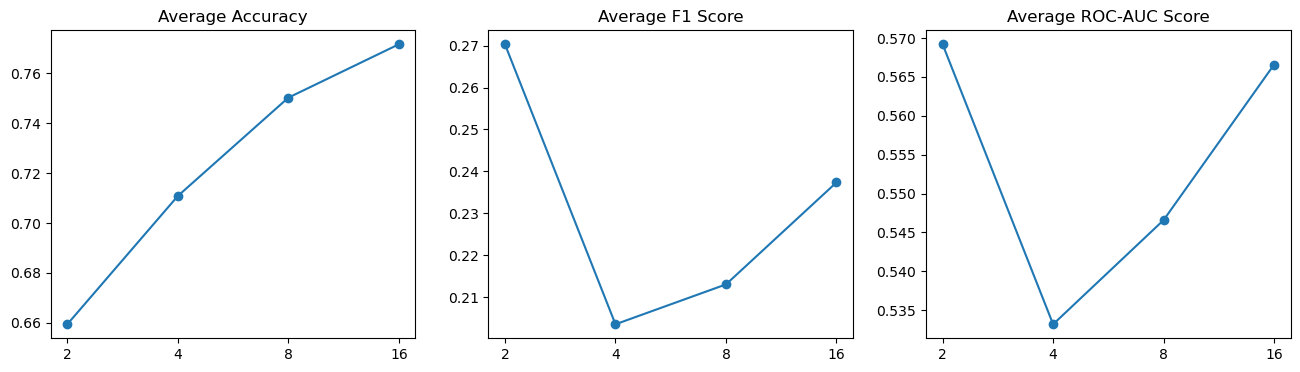

**********   Top 2   **********
Accuracy:       0.6594 +- 0.1205
F1 Score:       0.2703 +- 0.2059
ROC-AUC Score:  0.5692 +- 0.1688

**********   Top 4   **********
Accuracy:       0.7108 +- 0.1098
F1 Score:       0.2036 +- 0.2338
ROC-AUC Score:  0.5332 +- 0.161

**********   Top 8   **********
Accuracy:       0.7502 +- 0.1022
F1 Score:       0.2131 +- 0.2546
ROC-AUC Score:  0.5466 +- 0.1549

**********   Top 16   **********
Accuracy:       0.7716 +- 0.0985
F1 Score:       0.2374 +- 0.2773
ROC-AUC Score:  0.5666 +- 0.163



In [33]:
ttau_mutual_info_feats = [
    '# ADV (participant)', 'RatioVerb', '# CARDINAL (participant)', 'AvgVPTypeLengthNonEmbedded', '# unique lemmas (participant)',
    'MeanWordLength', 'VPTypeRate', 'proportion_below_threshold_0', 'AvgVPTypeLengthEmbedded', '# TIME (participant)',
    'NPTypeRate', 'MTLD (participant)', '# NOUN (participant)', '# GPE (participant)', 'RatioNoun',
    '# named entities (participant)', 'avg_cos_dist', 'tree_height (participant)', '# unique named entities (participant)', 'NP_to_DT_NN (participant)',
    'AvgNPTypeLengthNonEmbedded', 'ADVP_to_RB (participant)', 'VP_to_VBD_NP (participant)', '# VERB (participant)', 'VP_to_VBG_PP (participant)',
    'min_cos_dist', '# ORG (participant)', '# PERSON (participant)', 'PPTypeRate', 'NumberOfNID',
    'DisfluencyFrequency', 'VPProportion'
]#TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_rocs = check_top_features(X_ttau, y_ttau, ttau_mutual_info_feats)
plot_metrics(ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_rocs, ttau_mutual_info_feats)

In [34]:
ttau_mix_features = []
a, b = ttau_ml_feats[:8], ttau_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ttau_mix_features:
            ttau_mix_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ttau_mix_features:
            ttau_mix_features.append(b[idx])

ttau_mix_accs, ttau_mix_f1s, ttau_mix_rocs = check_top_features(X_ttau, y_ttau, ttau_mix_features, [2,4,8,16])


Checking top 2 features


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:08<00:00,  4.02it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]



Checking top 15 features


100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


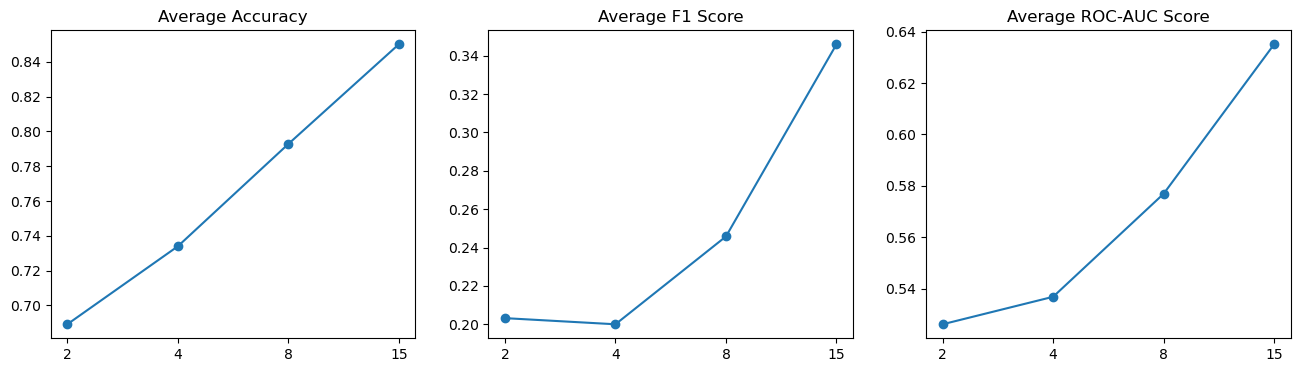

**********   Top 2   **********
Accuracy:       0.6892 +- 0.1117
F1 Score:       0.2032 +- 0.2184
ROC-AUC Score:  0.5261 +- 0.1587

**********   Top 4   **********
Accuracy:       0.734 +- 0.1028
F1 Score:       0.2 +- 0.2376
ROC-AUC Score:  0.5368 +- 0.1524

**********   Top 8   **********
Accuracy:       0.7928 +- 0.0914
F1 Score:       0.2458 +- 0.287
ROC-AUC Score:  0.5769 +- 0.1572

**********   Top 15   **********
Accuracy:       0.8501 +- 0.0751
F1 Score:       0.346 +- 0.3324
ROC-AUC Score:  0.6351 +- 0.1632



In [35]:
plot_metrics(ttau_mix_accs, ttau_mix_f1s, ttau_mix_rocs, ttau_mix_features)

### tTau_AB42Positivity final results

For tTau we see that our possible best case scenario is obtained using the `top 8 features` from the `ML approach`.</br>
In particular we have achieved an `accuracy of 0.8208 +- 0.0901` and an `F1 score of 0.3891 +- 0.3009`.

The top features are:
1. `MATTR (participant)`
2. `VP_to_AUX_VP (participant)`
3. `# TIME (participant)`
4. `RatioNoun`
5. `RatioVerb`
6. `tree_height (participant)`
7. `BrunetIndex`
8. `AvgNPTypeLengthNonEmbedded`

******************************************************************************************************************************************
******************************************************************************************************************************************

### AB42_AB40Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:27<00:00,  4.83it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


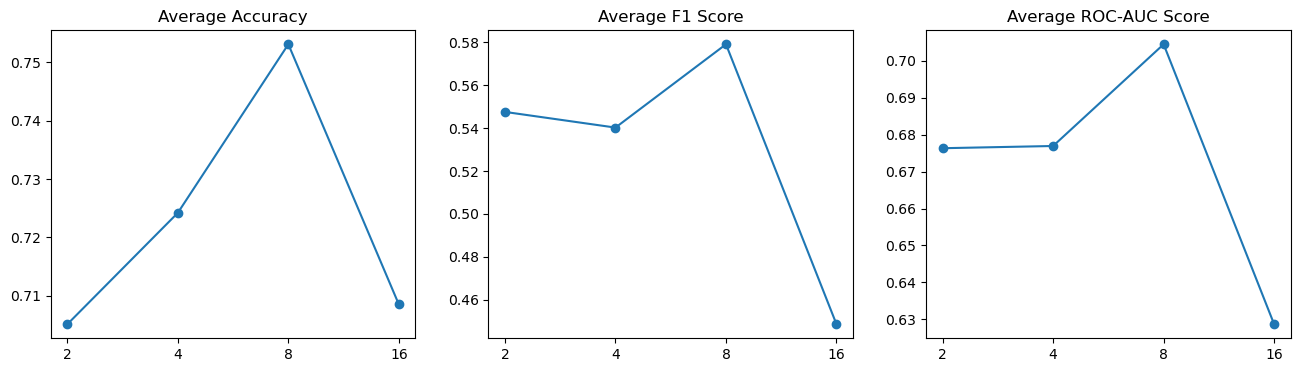

**********   Top 2   **********
Accuracy:       0.7051 +- 0.1121
F1 Score:       0.5475 +- 0.1743
ROC-AUC Score:  0.6763 +- 0.1238

**********   Top 4   **********
Accuracy:       0.7242 +- 0.111
F1 Score:       0.5402 +- 0.1907
ROC-AUC Score:  0.6769 +- 0.126

**********   Top 8   **********
Accuracy:       0.7531 +- 0.1116
F1 Score:       0.579 +- 0.1986
ROC-AUC Score:  0.7044 +- 0.131

**********   Top 16   **********
Accuracy:       0.7085 +- 0.1094
F1 Score:       0.4486 +- 0.226
ROC-AUC Score:  0.6287 +- 0.1308



In [36]:
ab42_ml_feats = [
    '# TIME (participant)', 'RatioVerb', 'VP_to_AUX_VP (participant)', 'RatioNoun', 'MATTR (participant)',
    '# NUM (participant)', '# PROPN (participant)', 'VPTypeRate', 'AvgNPTypeLengthNonEmbedded', 'tree_height (participant)',
    '# named entities (participant)', '# NOUN (participant)', 'VP_to_AUX (participant)', '# PUNCT (participant)', 'NPTypeRate',
    'RatioPronoun', '# ORDINAL (participant)', 'AvgPPTypeLengthEmbedded', 'PPTypeRate', '# ADV (participant)',
    'AvgVPTypeLengthEmbedded', 'VPProportion', '# unique named entities (participant)', 'BrunetIndex', '# SCONJ (participant)',
    'INTJ_to_UH (participant)', '# CCONJ (participant)', 'Maas (participant)', 'MeanWordLength', 'HonoreStatistic'
]#AB42_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ab42_ml_accs, ab42_ml_f1s, ab42_ml_rocs = check_top_features(X_ab42, y_ab42, ab42_ml_feats)
plot_metrics(ab42_ml_accs, ab42_ml_f1s, ab42_ml_rocs, ab42_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:27<00:00,  4.83it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


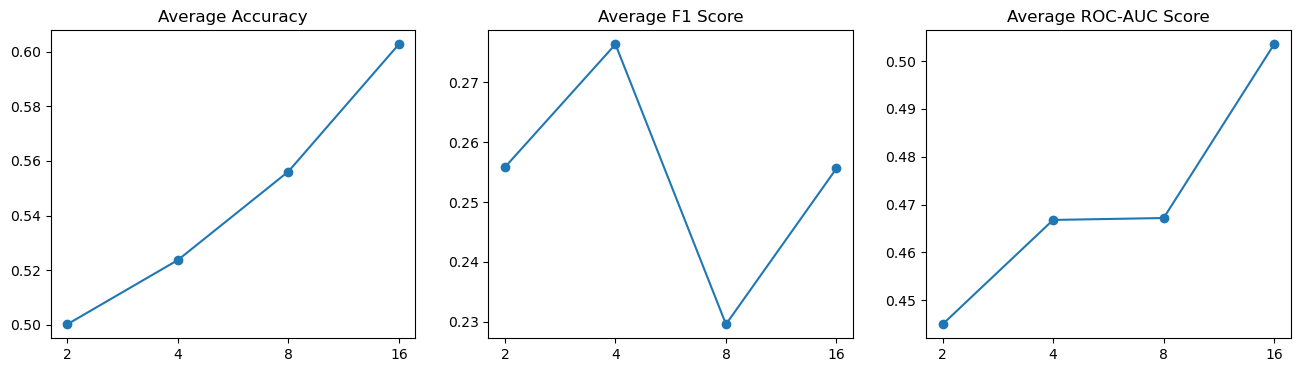

**********   Top 2   **********
Accuracy:       0.5002 +- 0.1236
F1 Score:       0.2558 +- 0.1741
ROC-AUC Score:  0.445 +- 0.1269

**********   Top 4   **********
Accuracy:       0.5237 +- 0.1201
F1 Score:       0.2763 +- 0.1779
ROC-AUC Score:  0.4668 +- 0.1245

**********   Top 8   **********
Accuracy:       0.5561 +- 0.1177
F1 Score:       0.2296 +- 0.1915
ROC-AUC Score:  0.4672 +- 0.1208

**********   Top 16   **********
Accuracy:       0.6027 +- 0.1162
F1 Score:       0.2556 +- 0.2049
ROC-AUC Score:  0.5035 +- 0.1197



In [37]:
ab42_f_classif_feats = [
    '# ADV (participant)', '# NUM (participant)', '# PUNCT (participant)', '# PROPN (participant)', 'tree_height (participant)',
    'VP_to_VBG (participant)', '# CCONJ (participant)', '# ORG (participant)', '# SCONJ (participant)', '# X (participant)',
    '# TIME (participant)', '# VERB (participant)', '# ADJ (participant)', '# ADP (participant)', '# AUX (participant)',
    'NP_to_PRP (participant)', '# INTJ (participant)', '# named entities (participant)', '# CARDINAL (participant)', '# PART (participant)',
    '# utterances (participant)', 'NP_to_DT_NN (participant)', '# tokens (participant)', '# GPE (participant)', '# unique named entities (participant)',
    '# unique tokens (participant)', '# DATE (participant)', '# DET (participant)', '# PRON (participant)', '# ORDINAL (participant)',
    '# unique lemmas (participant)'
]#AB42_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]


ab42_f_classif_accs, ab42_f_classif_f1s, ab42_f_classif_rocs = check_top_features(X_ab42, y_ab42, ab42_f_classif_feats)
plot_metrics(ab42_f_classif_accs, ab42_f_classif_f1s, ab42_f_classif_rocs, ab42_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.74it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.50it/s]


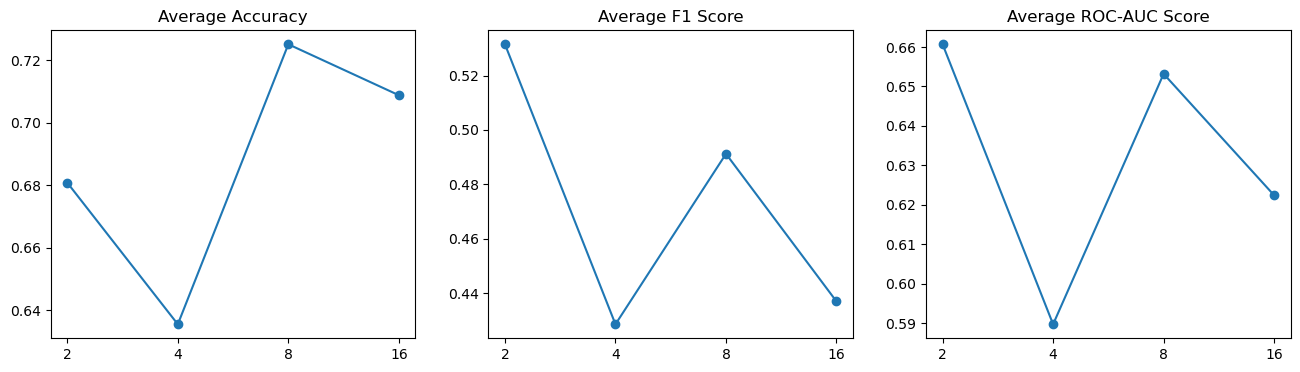

**********   Top 2   **********
Accuracy:       0.6808 +- 0.1184
F1 Score:       0.5315 +- 0.1742
ROC-AUC Score:  0.6607 +- 0.1275

**********   Top 4   **********
Accuracy:       0.6355 +- 0.1236
F1 Score:       0.4285 +- 0.1989
ROC-AUC Score:  0.5897 +- 0.1367

**********   Top 8   **********
Accuracy:       0.7251 +- 0.1074
F1 Score:       0.4912 +- 0.2167
ROC-AUC Score:  0.6532 +- 0.1291

**********   Top 16   **********
Accuracy:       0.7088 +- 0.1074
F1 Score:       0.4369 +- 0.2216
ROC-AUC Score:  0.6224 +- 0.1264



In [38]:
ab42_mutual_info_feats = [
    'AvgPPTypeLengthEmbedded', '# PROPN (participant)', 'DisfluencyFrequency', 'tree_height (participant)', 'VPTypeRate',
    '# TIME (participant)', '# CCONJ (participant)', '# NOUN (participant)', '# ADJ (participant)', 'AvgVPTypeLengthEmbedded',
    '# ADV (participant)', 'RatioVerb', '# PRON (participant)', 'INTJ_to_UH (participant)', 'MeanWordLength',
    'AvgNPTypeLengthNonEmbedded', '# ADP (participant)', '# ORDINAL (participant)', 'proportion_below_threshold_0', 'RatioNoun',
    'VP_to_AUX (participant)', '# AUX (participant)', '# unique named entities (participant)', 'NumberOfNID', '# PERSON (participant)',
    'VP_to_VBG_PP (participant)', '# INTJ (participant)', 'min_cos_dist', 'VP_to_VBD_NP (participant)', 'AvgVPTypeLengthNonEmbedded',
    '# X (participant)', 'ADVP_to_RB (participant)'
]#AB42_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ab42_mutual_info_accs, ab42_mutual_info_f1s, ab42_mutual_info_rocs = check_top_features(X_ab42, y_ab42, ab42_mutual_info_feats)
plot_metrics(ab42_mutual_info_accs, ab42_mutual_info_f1s, ab42_mutual_info_rocs, ab42_mutual_info_feats)

#### Mixed Sets

In [39]:
ab42_mixed_features = []
a, b = ab42_ml_feats[:8], ab42_mutual_info_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(b[idx])

In [40]:
ab42_top_accs, ab42_top_f1s, ab42_top_rocs = check_top_features(X_ab42, y_ab42, ab42_mixed_features)


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]



Checking top 13 features


100%|██████████| 1000/1000 [03:36<00:00,  4.63it/s]


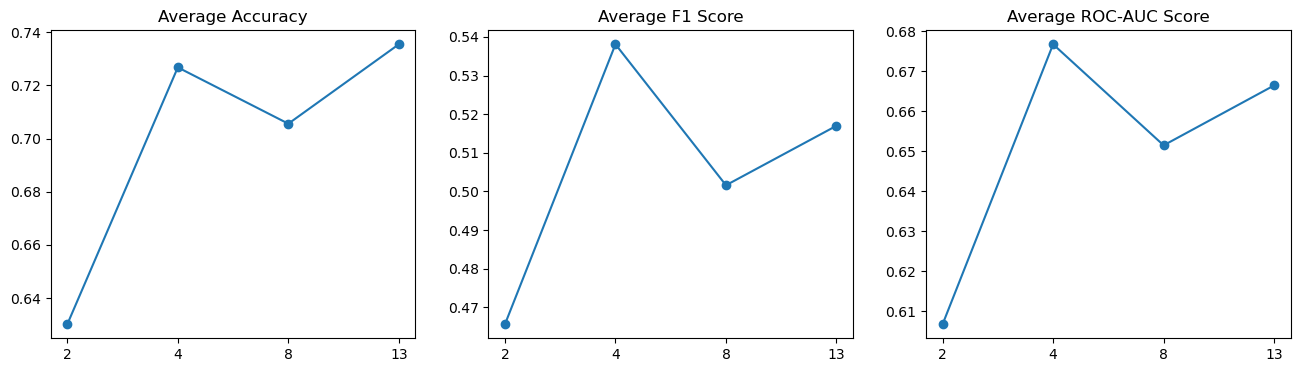

**********   Top 2   **********
Accuracy:       0.6301 +- 0.1154
F1 Score:       0.4656 +- 0.1685
ROC-AUC Score:  0.6067 +- 0.1263

**********   Top 4   **********
Accuracy:       0.7268 +- 0.1013
F1 Score:       0.5381 +- 0.185
ROC-AUC Score:  0.6768 +- 0.1176

**********   Top 8   **********
Accuracy:       0.7056 +- 0.1107
F1 Score:       0.5016 +- 0.1952
ROC-AUC Score:  0.6515 +- 0.1256

**********   Top 13   **********
Accuracy:       0.7355 +- 0.1113
F1 Score:       0.517 +- 0.2118
ROC-AUC Score:  0.6665 +- 0.13



In [41]:
plot_metrics(ab42_top_accs, ab42_top_f1s, ab42_top_rocs, ab42_mixed_features)

### AB42_AB40Positivity final results

In the end, the `top 8 ML features` achieve the top accuracy and F1 score without any other method even coming close.</br>
In particular we achieved an `accuracy of 0.7555 +- 0.1132` and an `F1 score of 0.5784 +- 0.2051`.

The features are:
1. `# TIME (participant)`
2. `RatioVerb`
3. `VP_to_AUX_VP (participant)`
4. `RatioNoun`
5. `MATTR (participant)`
6. `# NUM (participant)`
7. `# PROPN (participant)`
8. `VPTypeRate`

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [72]:
def load_exp(selected_feats, target, typ=int, audio=False):
    # Load the entire csv file
    data = pd.read_csv('data/full_corrected.csv' if audio else 'data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [8]:
import seaborn as sns

MOCA_EXP_FEATS = [
    '# DATE (participant)', 'RatioVerb', '# AUX (participant)', '# unique tokens (participant)',
    'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', '# VERB (participant)', 'proportion_below_threshold_0.5'
 ]
TTAU_EXP_FEATS = [
    'MATTR (participant)', 'VP_to_AUX_VP (participant)', '# TIME (participant)', 'RatioNoun',
    'RatioVerb', 'tree_height (participant)', 'BrunetIndex', 'AvgNPTypeLengthNonEmbedded'
]
AB42_EXP_FEATS = [
    '# TIME (participant)', 'RatioVerb', 'VP_to_AUX_VP (participant)', 'RatioNoun',
    'MATTR (participant)', '# NUM (participant)', '# PROPN (participant)', 'VPTypeRate'
]

TARGETS = ['MOCA_impairment', 'tTau_AB42Positivity', 'AB42_AB40Positivity']

In [61]:
TTAU_EXP_FEATS_AUDIO = [
    'PU', 'UP', 'VP', 'PVU', 'maxdurpause',
    'stddurpause', '1F0std', 'avgdurvoiced'
]

## Variable Correlation

In [128]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target) in enumerate(zip([MOCA_EXP_FEATS, TTAU_EXP_FEATS, AB42_EXP_FEATS], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        fixed = corr_df.columns.to_list()
        for _idx in range(len(fixed)):
            if fixed[_idx] == 'AvgVPTypeLengthEmbedded':
                fixed[_idx] = 'AvgVPType\nLengthEmbedded'
            if fixed[_idx] == 'AvgNPTypeLengthNonEmbedded':
                fixed[_idx] = 'AvgNPType\nLengthNon\nEmbedded'
            if fixed[_idx] == 'proportion_below_threshold_0.5':
                fixed[_idx] = 'proportion_below\nthreshold_0.5'
        corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[target if not special else special[idx]]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[target if not special else special[idx]]))
    return series, annots

In [125]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=3, figsize=(12,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    sns.heatmap(series[2], annot=annots[2], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[2]], fmt = '')
    plt.subplots_adjust(wspace=1.4, top=0.92)
    plt.show()

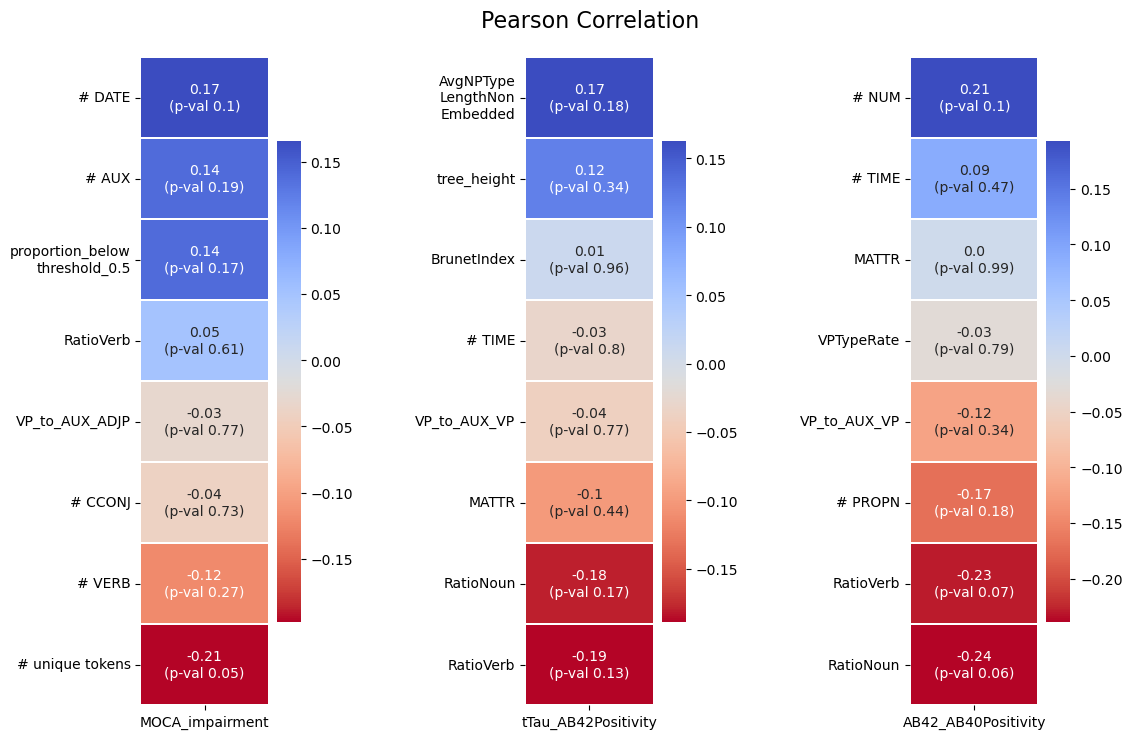

In [129]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

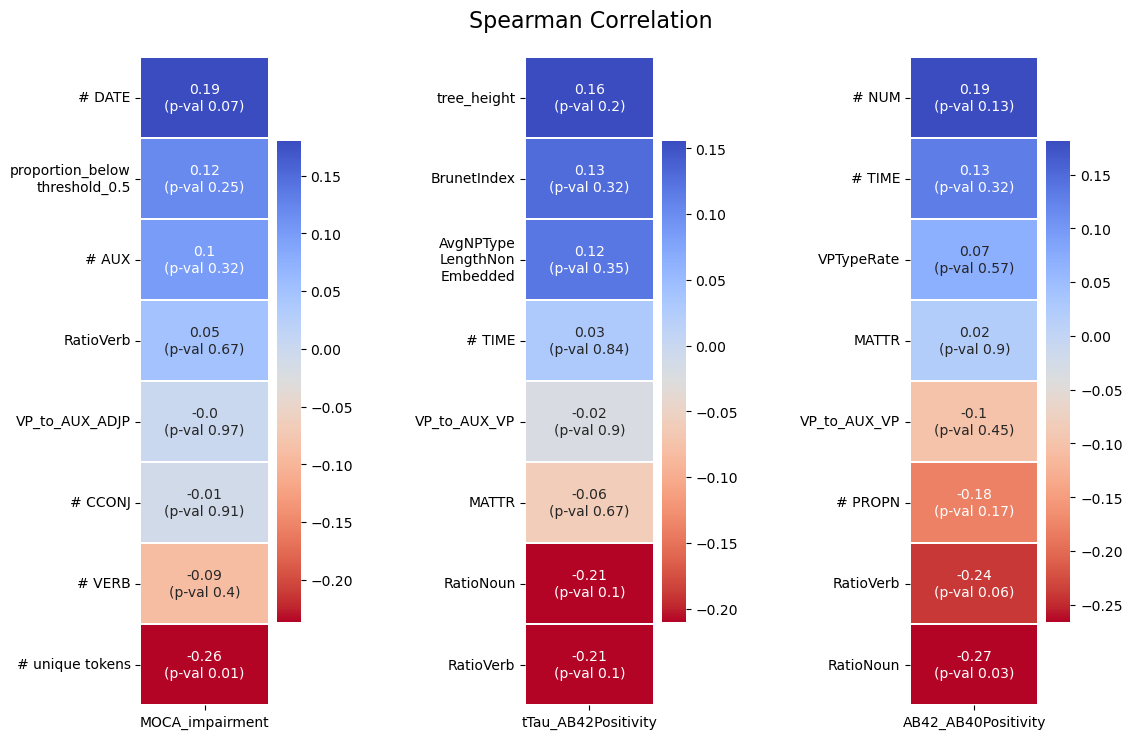

In [130]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

### MOCA
Even taking into consideration both of the correlation functions, only one feature has statistical relevance: `# unique tokens`. Not exactly perfect, but the only meaningful results is also exactly what we do expect: someone healthy should probably generate more unique tokens given more complex/rich language patterns. Thus, the higher `# unique tokens` is, the lower is the probability of observing a dementia patient.

### tTau
Same story as MOCA, the only element that showed some statistical significance (only with Pearson correlation coefficients) is `BrunetIndex`. Once again, this also goes in the direction that we expected because higher BrunetIndex relates to less complex language patterns, so a high BrunetIndex correlates positively with dementia.

### AB42
Here we have 2 features that correlate negatively with Dementia: `RatioVerb` and `RatioNoun`. Also, we see that `MATTR` do not really correlates to anything (at least if we look at the Pearson correlation).

## WRT Clinical Diagnosis

In [72]:
# Filters
def filter_ad(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'MCI'].index)

def filter_mci(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'Prob AD'].index)

In [73]:
# Encodings
def encode_ad_mci(x):
    if x == 'Normal' or x=='Normal-PD':
        return 0
    return 1

def encode_ad(x):
    if x == 'Prob AD':
        return 1
    return 0
        
def encode_mci(x):
    if x == 'MCI':
        return 1
    return 0

### Control vs Prob AD

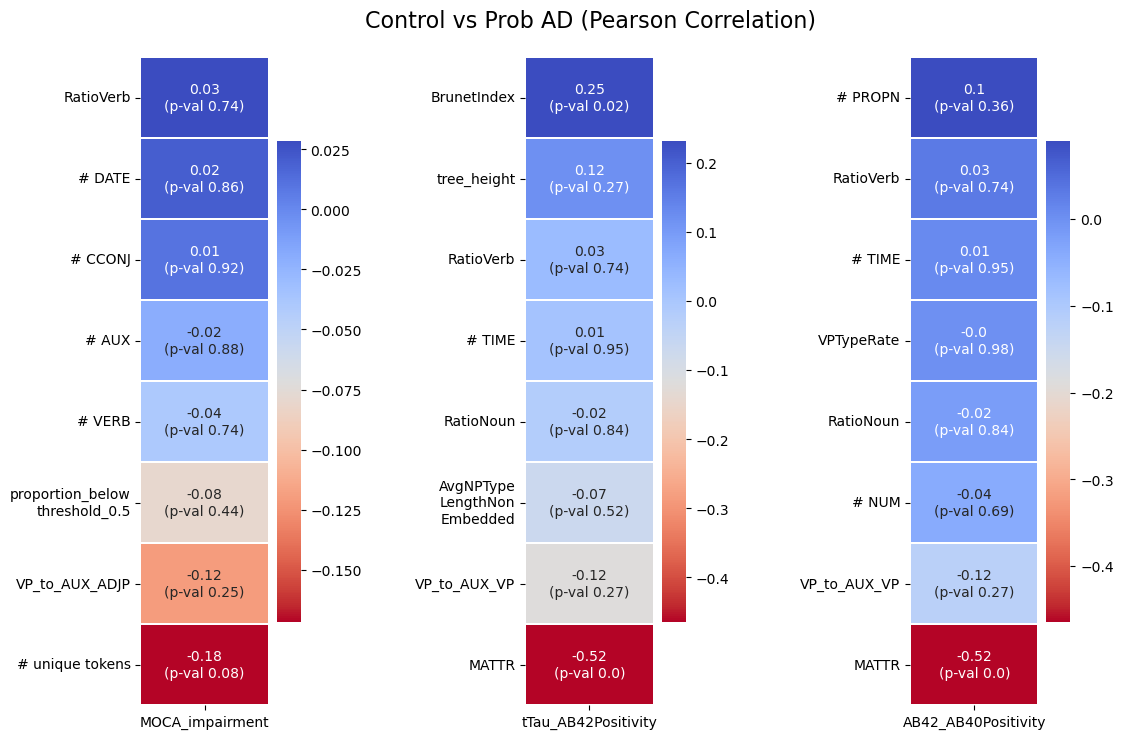

In [131]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Pearson Correlation)")

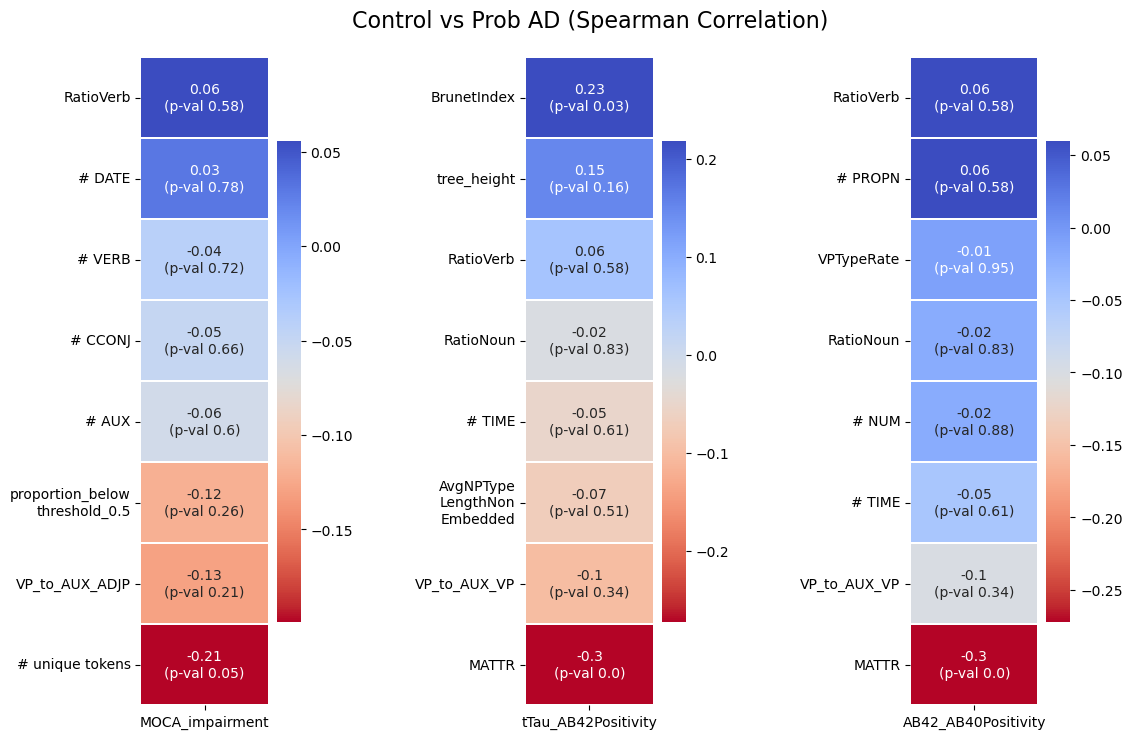

In [132]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Spearman Correlation)")

### MOCA Features
No values with statistical significance.

### tTau Features
Both `MATTR` and `BrunetIndex` show the exact correlation that we may expect (high MATTR = healthy, and high BrunetIndex = dementia).

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI

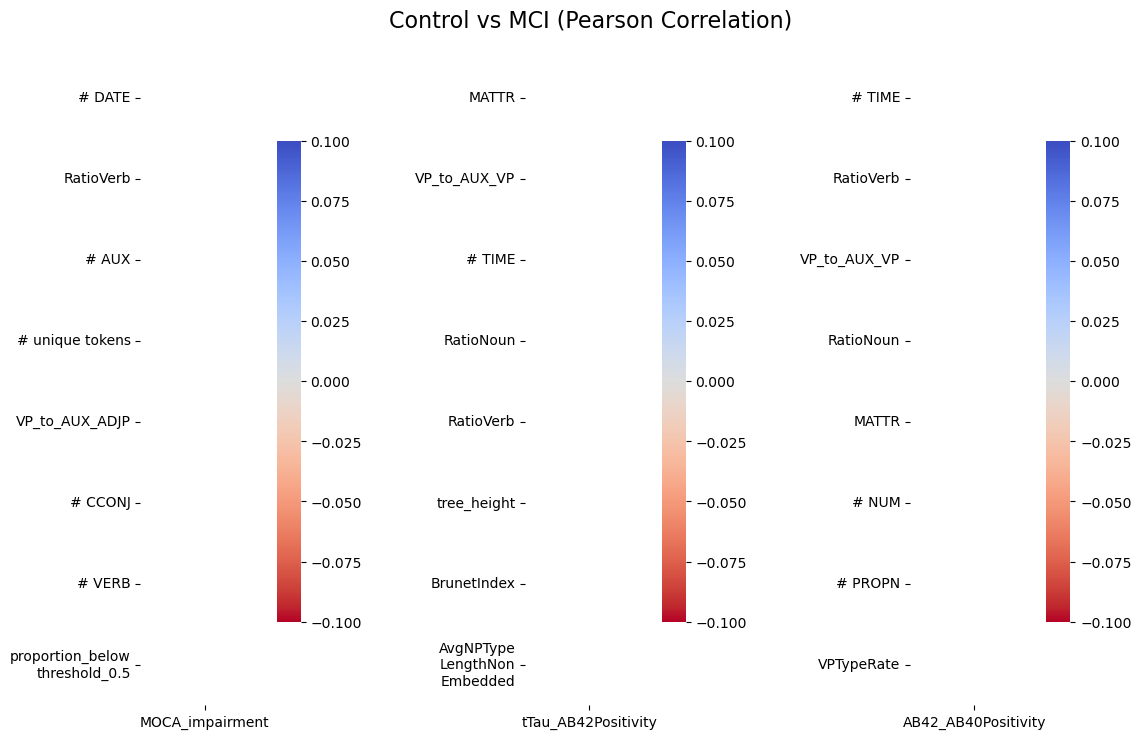

In [133]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_mci, encoding=encode_mci)
plot_correlation(series, annots, "Control vs MCI (Pearson Correlation)")

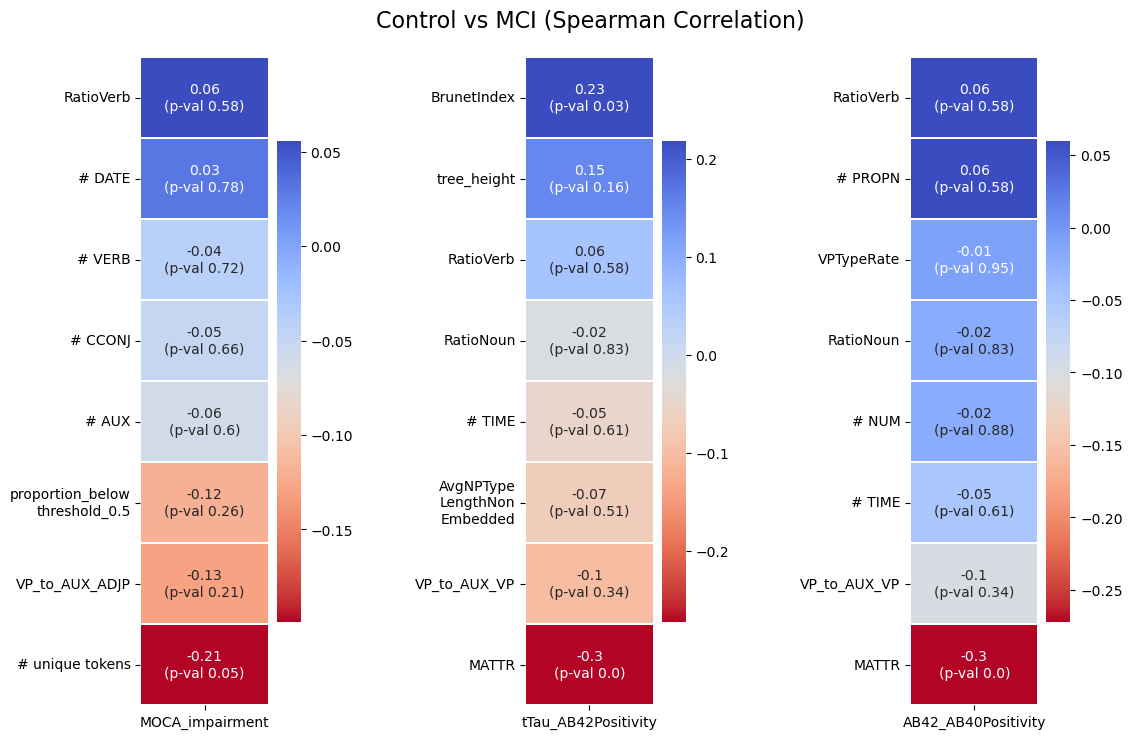

In [134]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI (Spearman Correlation)")

Interestingly, the Pearson correlation refused to produce any values for this experiment. Still unclear if this is a coding problem, or a data problem.

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
Expected correlation for `MATTR`.

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI & Prob AD

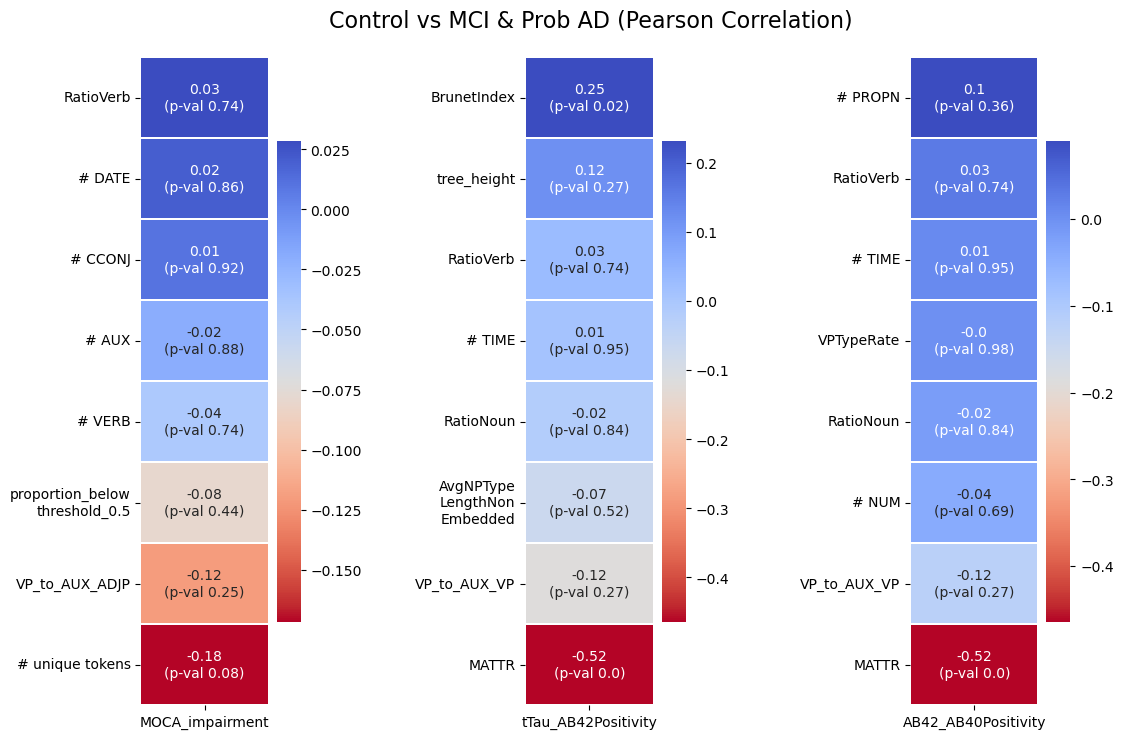

In [135]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Pearson Correlation)")

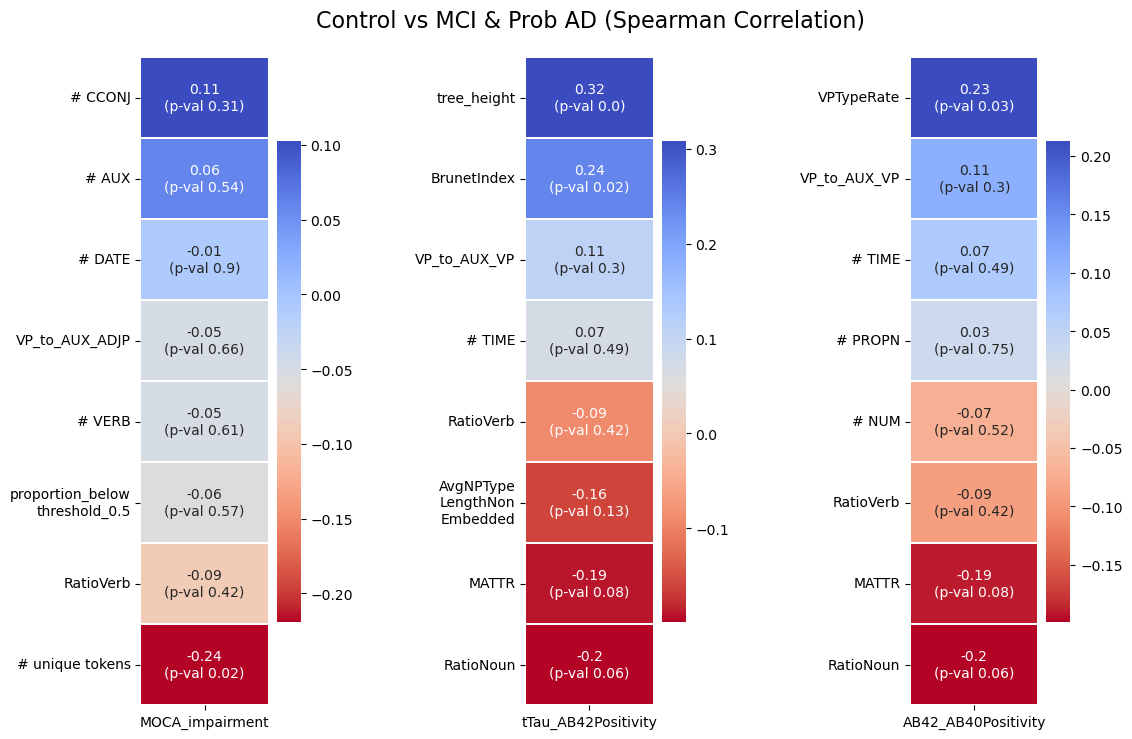

In [136]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, encoding=encode_ad_mci)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Spearman Correlation)")

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
`tree_height` seems to be strongly correlated to dementia parient, and the possible explanation is related to the fact that dementia patient connect a lot of utterances with `AND`, and the tree may have been generated counting all these connected utterances as part of the same sentence, thus generating one enormous tree.

### AB42 Features
No significant values.

## Shap Values

In [62]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [64]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [65]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [66]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [67]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [73]:
def explain(target, features, cv_repetitions, seeds, audio=False):
    df = load_exp(features, target, audio=audio)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [69]:
def plot_shap_vals(X: pd.DataFrame, average_values, label, cv_repetitions):
    cols = []
    for col in list(X.columns):
        if col == 'proportion_below_threshold_0.5':
            col = 'proportion_below\nthreshold_0.5'
        if col == 'AvgNPTypeLengthNonEmbedded':
            col = 'AvgNPTypeLength\nNonEmbedded'
        cols.append(col)
    X.columns = cols
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.xlabel('')
    plt.show()

In [70]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### MOCA_impairment

In [17]:
MOCA_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_moca_exp, moca_class_0, moca_class_1 = explain('MOCA_impairment', MOCA_EXP_FEATS, CV_REPETITIONS, MOCA_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


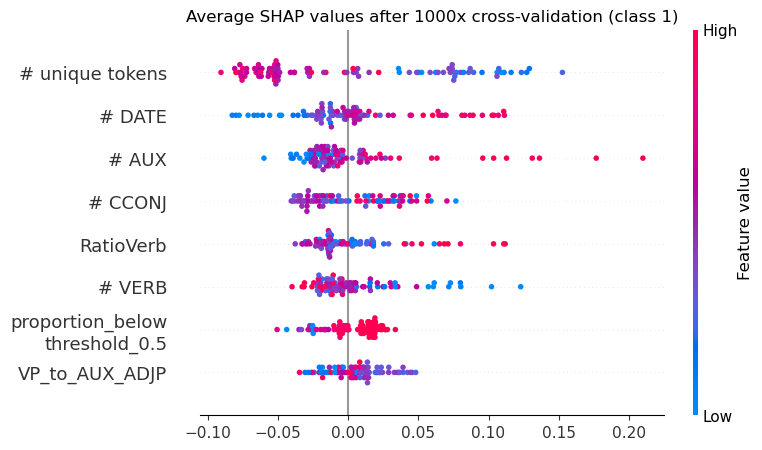

In [18]:
plot_shap_vals(X_moca_exp, moca_class_1[0], 1, CV_REPETITIONS)

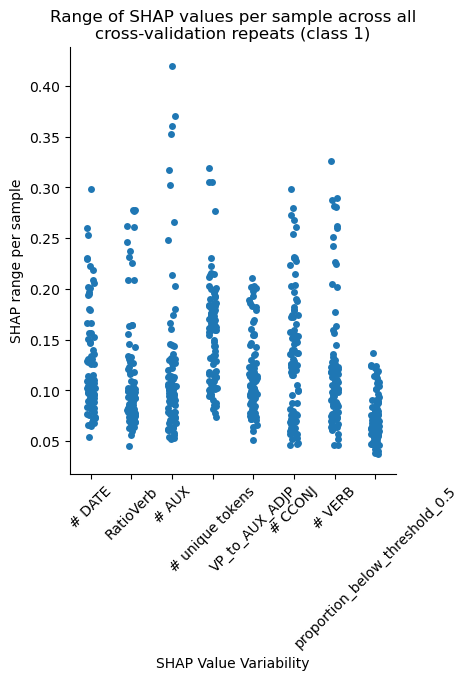

In [101]:
plot_ranges(X_moca_exp, moca_class_1[2], 1)

### tTau_AB42Positivity (no Audio)

In [19]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('tTau_AB42Positivity', TTAU_EXP_FEATS, CV_REPETITIONS, TTAU_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:46<00:00,  1.13it/s]


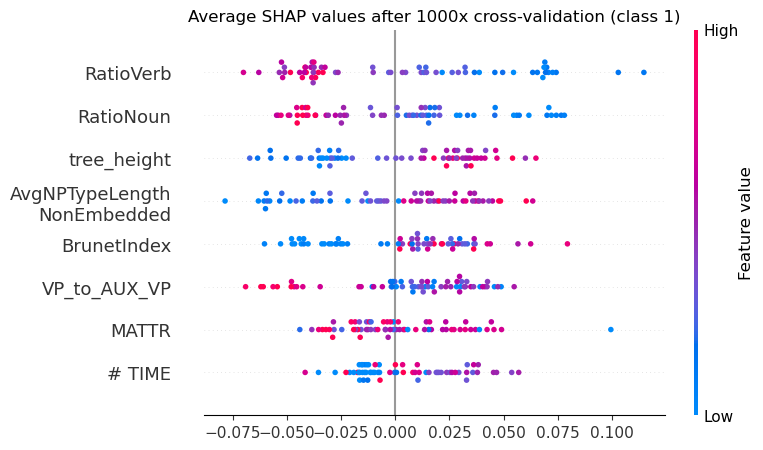

In [20]:
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

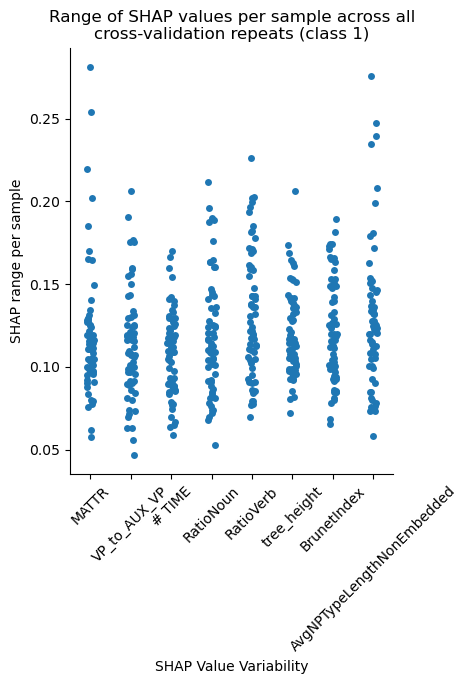

In [103]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### tTau_AB42Positivity (Full)

In [75]:
TTAU_AUDIO_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp_audio, ttau_class_0_audio, ttau_class_1_audio = explain('tTau_AB42Positivity', TTAU_EXP_FEATS_AUDIO, CV_REPETITIONS, TTAU_AUDIO_SEEDS, audio=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:54<00:00,  1.12it/s]


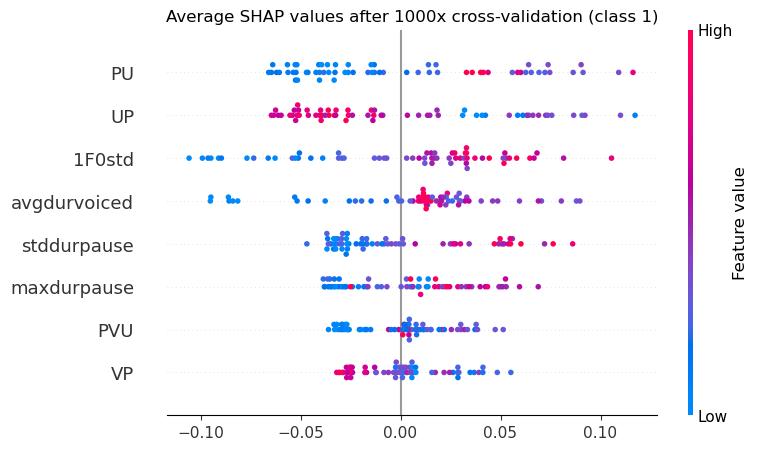

In [76]:
plot_shap_vals(X_ttau_exp_audio, ttau_class_1_audio[0], 1, CV_REPETITIONS)

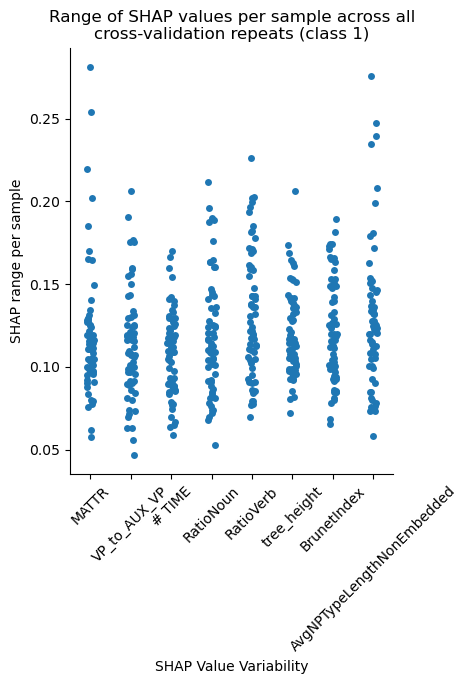

In [ ]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### AB42_AB40Positivity

In [21]:
AB42_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ab42_exp, ab42_class_0, ab42_class_1 = explain('AB42_AB40Positivity', AB42_EXP_FEATS, CV_REPETITIONS, AB42_SEEDS)

100%|██████████| 1000/1000 [14:55<00:00,  1.12it/s]


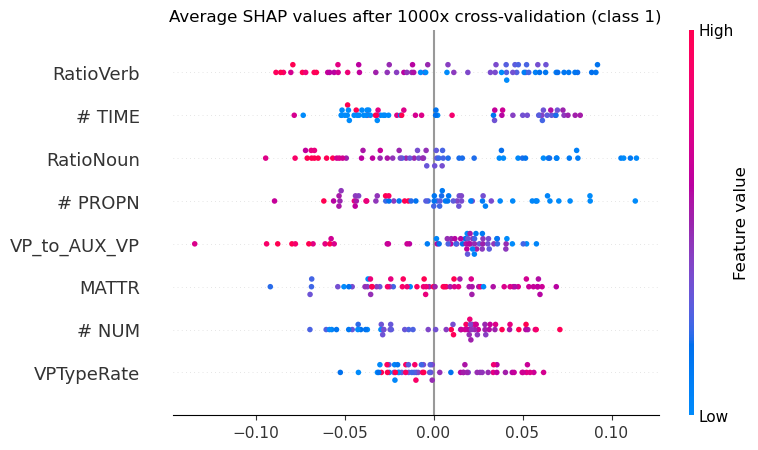

In [22]:
plot_shap_vals(X_ab42_exp, ab42_class_1[0], 1, CV_REPETITIONS)

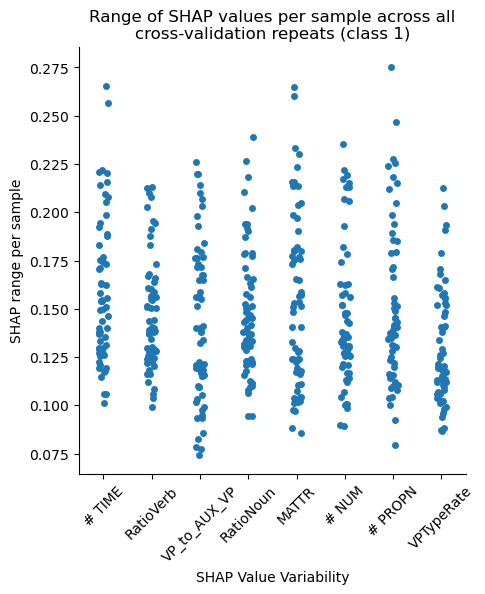

In [106]:
plot_ranges(X_ab42_exp, ab42_class_1[2], 1)

# Courpus Analysis

In [31]:
a = DATA['Age_at_testing'].tolist()
import statistics as stat
print(stat.stdev(a))

5.8386467940154185
